In [50]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [51]:
import pandas as pd
import numpy as np
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
import matplotlib.pyplot as plt

In [52]:
# reading the features file into df
unclear_filtered = pd.read_csv("features_output_final.csv")
unclear_filtered = unclear_filtered.copy()
unclear_filtered["Modification_LNA/deoxy"]

0        False
1        False
2        False
3        False
4        False
         ...  
25996    False
25997    False
25998    False
25999    False
26000    False
Name: Modification_LNA/deoxy, Length: 26001, dtype: bool

In [53]:
modification_col = [col for col in unclear_filtered.columns if col.startswith("Modification_")]
modification_col


['Modification_fraction',
 'Modification_type_count',
 'Modification_5prime_run',
 'Modification_3prime_run',
 'Modification_compute_mod_min_distance_to_5prime',
 'Modification_min_distance_to_3prime',
 'Modification_pos_std',
 'Modification_block_count',
 'Modification_max_block_length',
 'Modification_char_entropy',
 'Modification_dominant_mod_fraction',
 'Modification_evenness',
 'Modification_symmetry_score',
 'Modification_skew_index',
 'Modification_mean_gap',
 'Modification_local_density_max',
 'Modification_in_core',
 'Modification_longest_repeat_run',
 'Modification_adjacent_pair_count',
 'Modification_strong_repeat_group_count',
 'Modification_(S)-cEt/5-methylcytosines/MOE/deoxy',
 'Modification_(S)-cEt/5-methylcytosines/deoxy',
 'Modification_LNA/deoxy',
 'Modification_MOE/5-methylcytosines/deoxy',
 'Modification_MOE/cEt/5-methylcytosines/deoxy',
 'Modification_MOE/cEt/o-methylribose/5-methylcytosines/deoxy',
 'Modification_cEt/5-methylcytosines/deoxy',
 'Modification_cEt/o-

roups rows that have the same values across all non-target columns

In [54]:


# Step 1: Specify the value columns to aggregate
value_columns = ['Inhibition(%)', 'log_inhibition']

# Step 2: Create a grouping key from all other columns
unclear_filtered['_merge_key'] = (
    unclear_filtered
    .drop(columns=value_columns)
    .astype(str)
    .agg('_'.join, axis=1)
)

# Step 3: Group by that key and calculate mean of the value columns
agg_result = unclear_filtered.groupby('_merge_key', as_index=False)[value_columns].mean()

# Step 4: Drop duplicates and join back the original context
dedup_context = unclear_filtered.drop_duplicates('_merge_key').drop(columns=value_columns)
filtered = pd.merge(dedup_context, agg_result, on='_merge_key').drop(columns=['_merge_key'])





In [55]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

finding the correlations for each feature

In [56]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def compute_entropy(series, bins=20):
    series = series.astype(float)
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def analyze_feature_correlations(df, target, features=None, verbose=False, bins=20):
    """
    Analyzes Pearson, Spearman, and Normalized Mutual Information (NMI_max) between features and a target variable.

    Parameters:
    -----------
    df : pd.DataFrame
    target : str
        Name of the target column.
    features : list of str, optional
        Feature names. If None, use all columns except the target.
    verbose : bool
        Print error messages if True.
    bins : int
        Number of bins for entropy estimation.

    Returns:
    --------
    pd.DataFrame with Pearson, Spearman, and NMI_max results.
    """
    if features is None:
        features = [col for col in df.columns if col != target]

    results = []

    for feature in features:
        try:
            # Drop rows with NaN in either the feature or the target
            valid_mask = df[[feature, target]].notnull().all(axis=1)
            x = df.loc[valid_mask, feature].values
            y = df.loc[valid_mask, target].values

            # Skip if there's not enough data
            if len(x) < 3:
                raise ValueError("Not enough valid data points.")

            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)
            mi = mutual_info_regression(x.reshape(-1, 1), y, discrete_features='auto')[0]

            H_x = compute_entropy(x, bins=bins)
            H_y = compute_entropy(y, bins=bins)

            nmi_max = mi / max(H_x, H_y) if max(H_x, H_y) > 0 else np.nan

            results.append({
                'Feature': feature,
                'Pearson': round(pearson_corr, 3),
                'Spearman': round(spearman_corr, 3),
                'NMI_max': round(nmi_max, 3)
            })

        except Exception as e:
            if verbose:
                print(f"Error with feature '{feature}': {e}")
            results.append({
                'Feature': feature,
                'Pearson': None,
                'Spearman': None,
                'NMI_max': None
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by="NMI_max", ascending=False, inplace=True)
    return results_df


In [57]:
import matplotlib.pyplot as plt

def plot_feature_correlations_by_prefix(results_df, prefix, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for features starting with a given prefix.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results (from analyze_feature_correlations).
    prefix : str
        The prefix to filter feature names (e.g., 'tAI_score').
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by prefix
    subset_df = results_df[results_df['Feature'].str.startswith(prefix)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", 'NMI_max'])
    
    if subset_df.empty:
        print(f"No features found starting with '{prefix}'")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title(f"Correlation Metrics for Features Starting with '{prefix}'")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def plot_selected_feature_correlations_from_list(results_df, feature_list, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for a given list of features.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results.
    feature_list : list of str
        The list of feature names to include in the plot.
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by exact name match from list
    subset_df = results_df[results_df['Feature'].isin(feature_list)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", "NMI_max"])
    
    if subset_df.empty:
        print("No matching features found in the provided list.")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title("Correlation Metrics for Selected Features")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [58]:
results_df = analyze_feature_correlations(filtered, target='log_inhibition')
display(results_df)

/tmp/ipykernel_2173189/3995343351.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/tmp/ipykernel_2173189/3995343351.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


,Feature,Pearson,Spearman,NMI_max
268,Inhibition(%),0.889,1.000,2.484
0,ISIS,0.094,-0.122,0.210
3,ASO_volume(nM),0.284,0.284,0.092
85,tAI_score_global_CDS,0.081,0.049,0.086
62,sense_start,0.119,0.258,0.083
...,...,...,...,...
10,Linkage_Location,NaN,NaN,NaN
11,Smiles,NaN,NaN,NaN
13,Canonical Gene Name,NaN,NaN,NaN
14,Cell line organism,NaN,NaN,NaN


lets display the correlations of the features

Global CDS features:


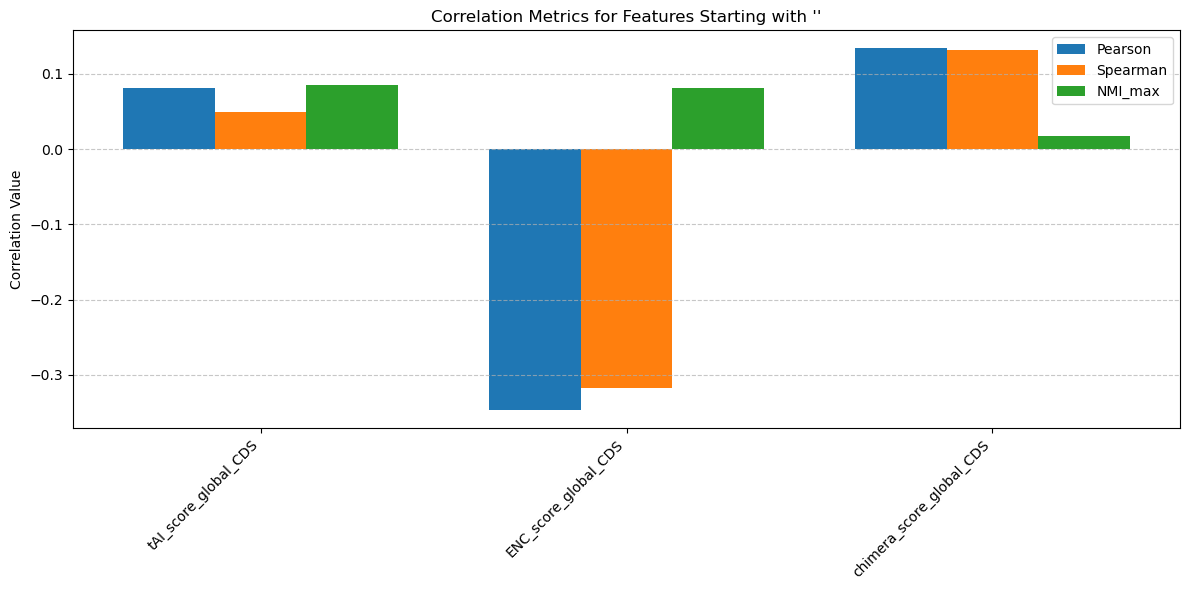

In [59]:
mask = ~results_df["Feature"].str.endswith("_global_CDS")
results_df_without_global = results_df[mask]
suffix = "score_global_CDS"
global_result_df = results_df[results_df['Feature'].str.endswith(suffix)]

print("Global CDS features:")
plot_feature_correlations_by_prefix(global_result_df, prefix='')

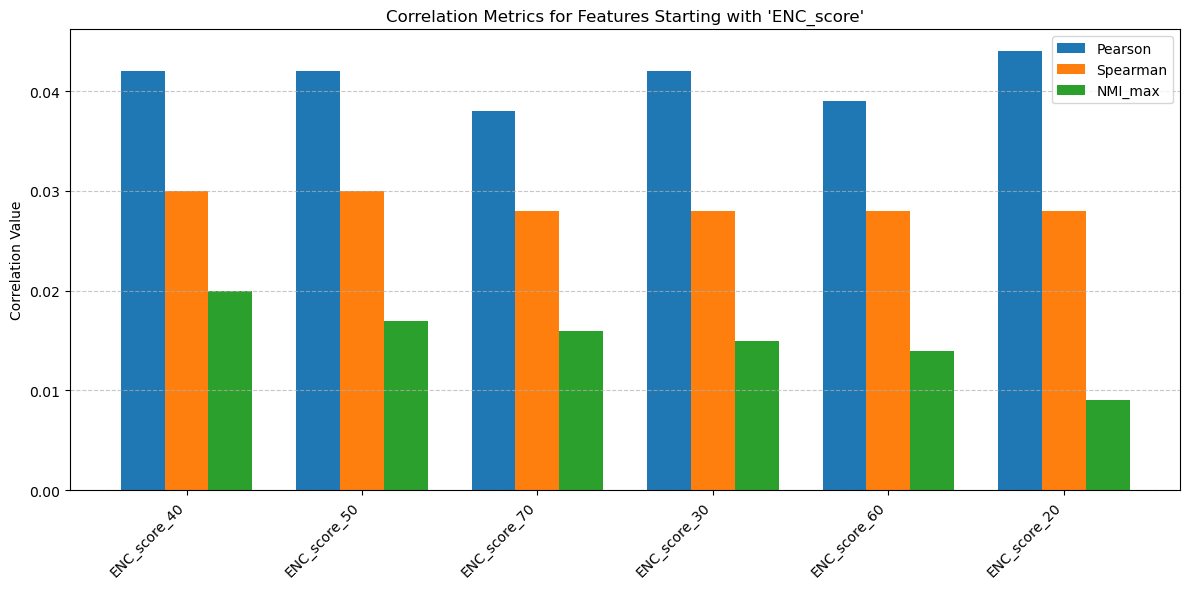

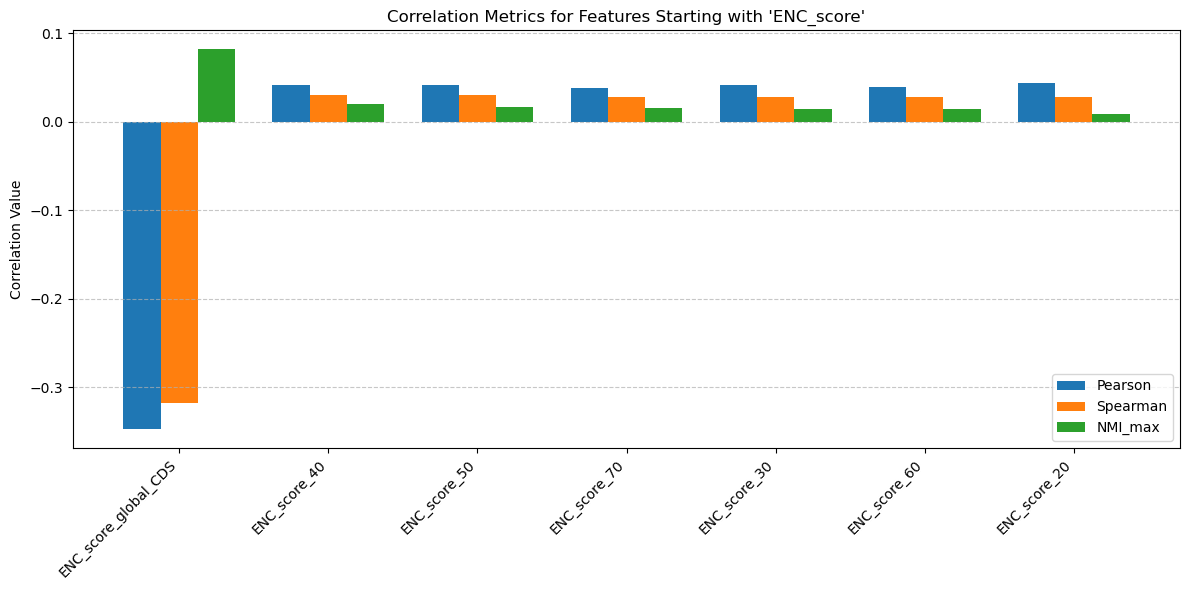

In [60]:
#ENC_score features
plot_feature_correlations_by_prefix(results_df_without_global, prefix='ENC_score')
plot_feature_correlations_by_prefix(results_df, prefix='ENC_score')

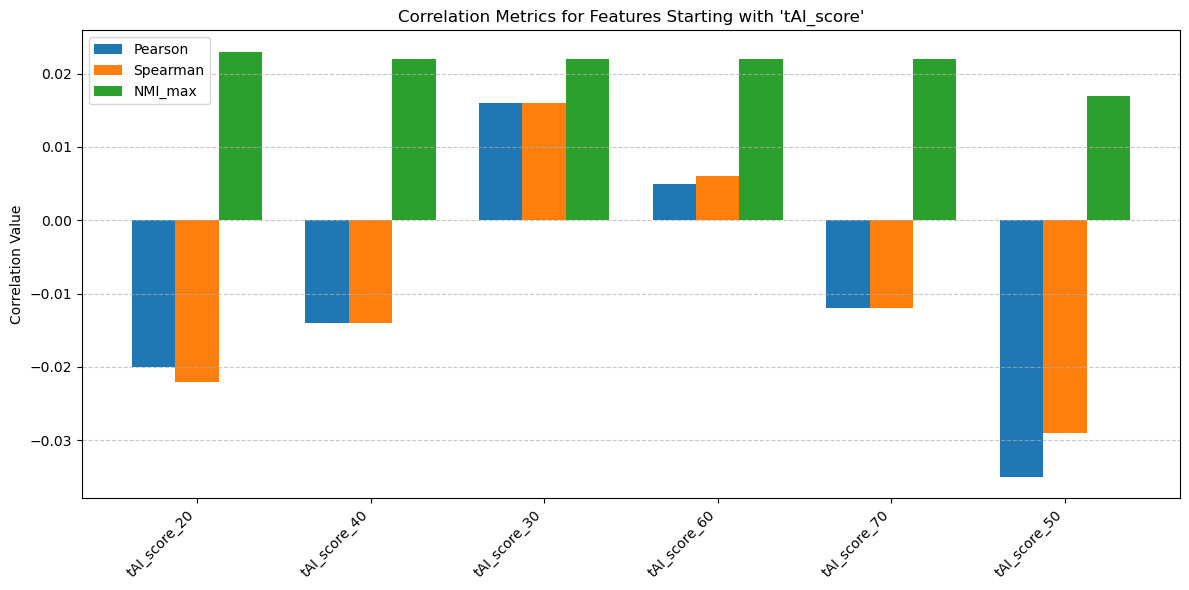

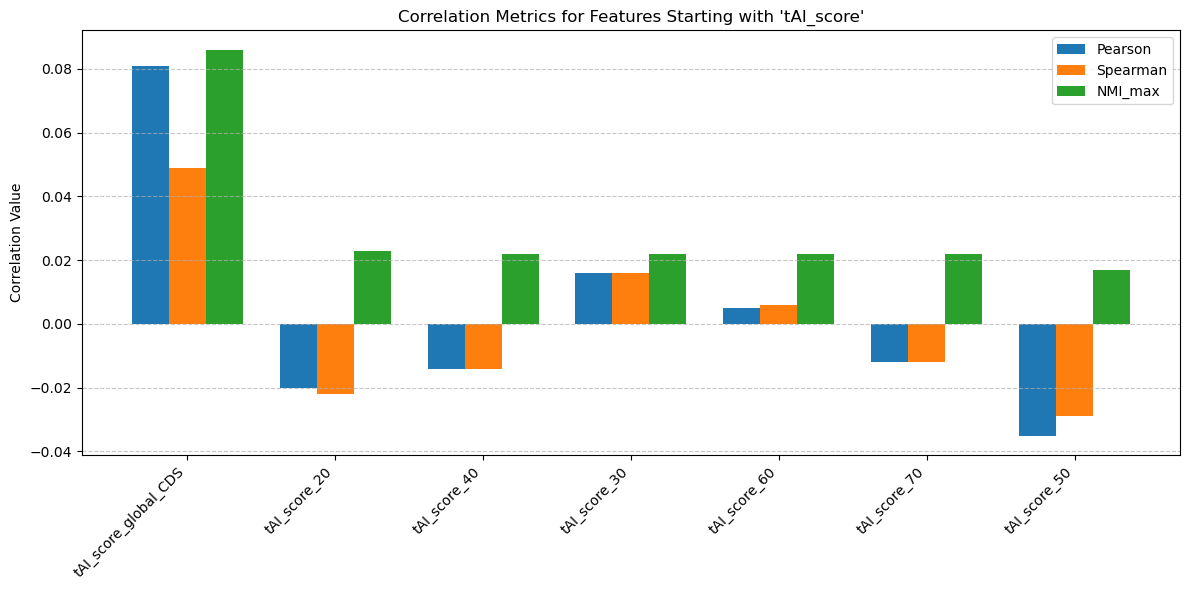

In [61]:
plot_feature_correlations_by_prefix(results_df_without_global, prefix='tAI_score')
plot_feature_correlations_by_prefix(results_df, prefix='tAI_score')

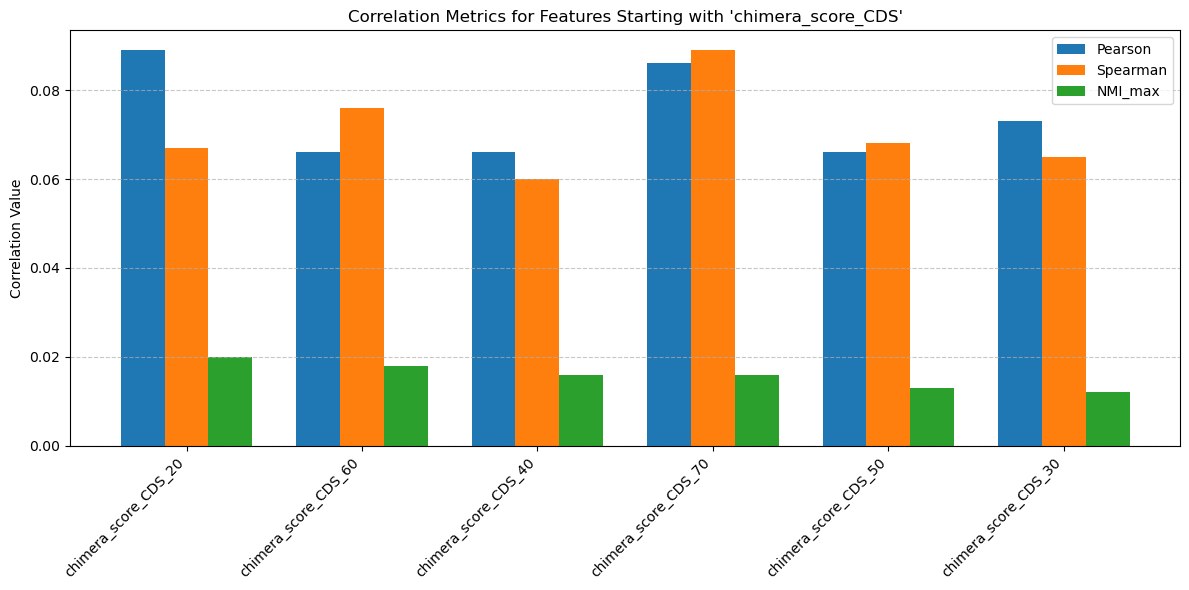

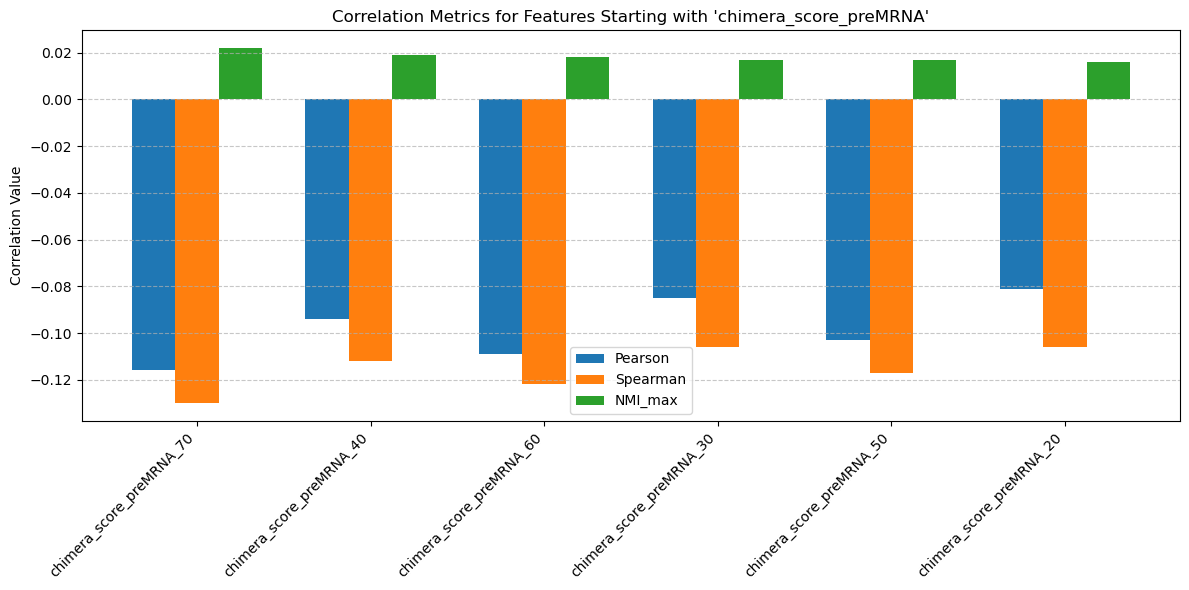

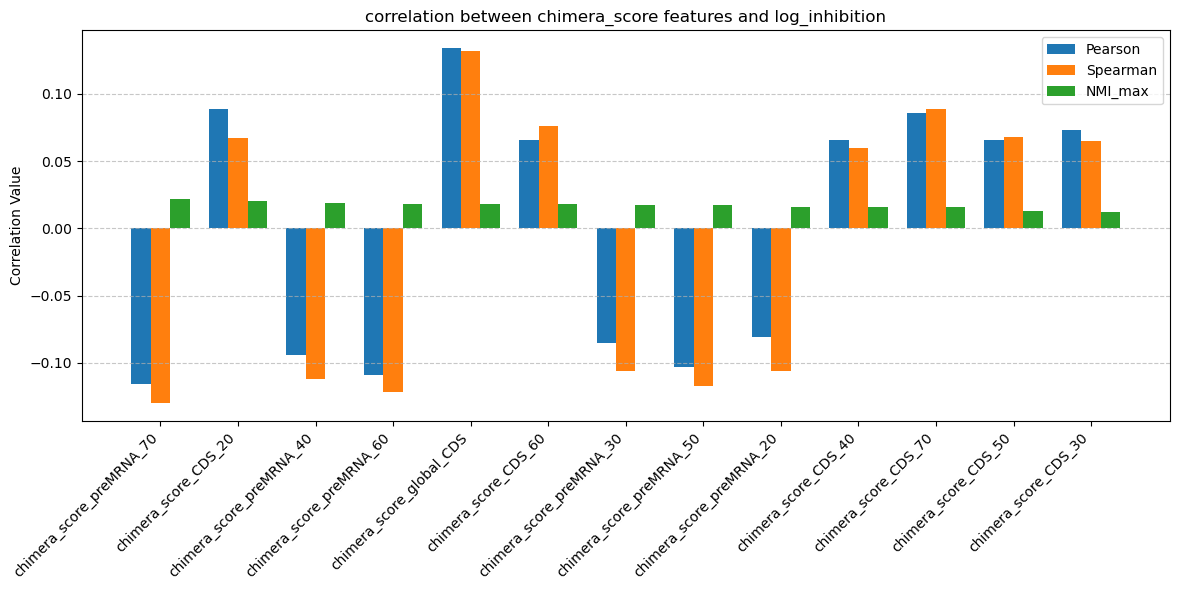

In [62]:
plot_feature_correlations_by_prefix(results_df_without_global, prefix='chimera_score_CDS')
plot_feature_correlations_by_prefix(results_df, prefix='chimera_score_preMRNA')
plot_feature_correlations_by_prefix(results_df, prefix='chimera_score', title="correlation between chimera_score features and log_inhibition")

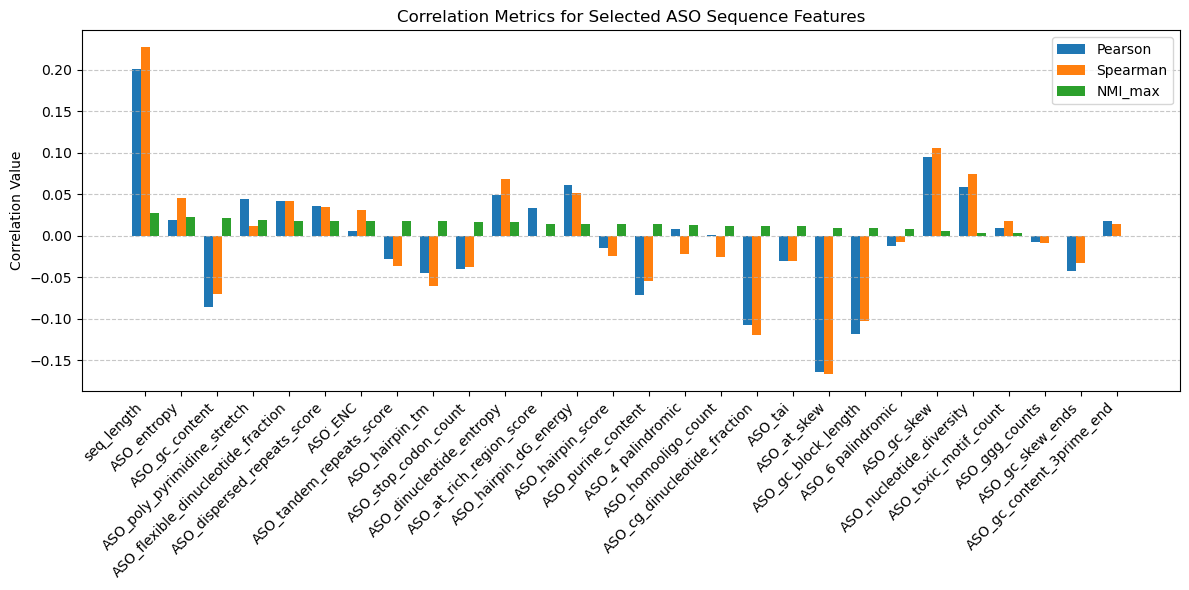

In [63]:
# Plotting specific features of interest
aso_seq_features = [ col for col in filtered.columns if col.startswith("ASO")]
aso_seq_features.append("seq_length")
aso_seq_features.remove('ASO_volume(nM)')
#aso_seq_features = ["ASOֹ_ENC","seq_length","flexible_dinucleotide_fraction","at_rich_region_score","purine_content","stop_codon_count","tandem_repeats_score","4 palindromic","entropy","dispersed_repeats_score","hairpin_score","dinucleotide_entropy","at_skew","gc_skew","gc_block_length","ASO_tai","cg_dinucleotide_fraction","nucleotide_diversity","6 palindromic","gc_skew_ends","toxic_motif_count","ggg_counts","gc_content"]
plot_selected_feature_correlations_from_list(results_df, aso_seq_features, sort_by='NMI_max', title="Correlation Metrics for Selected ASO Sequence Features")

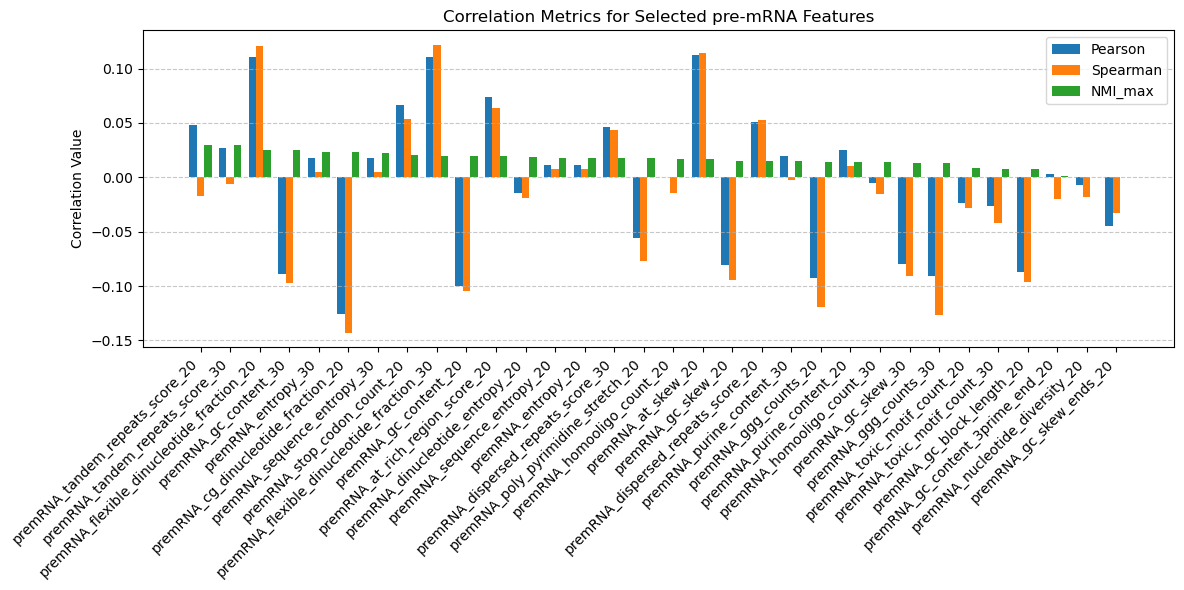

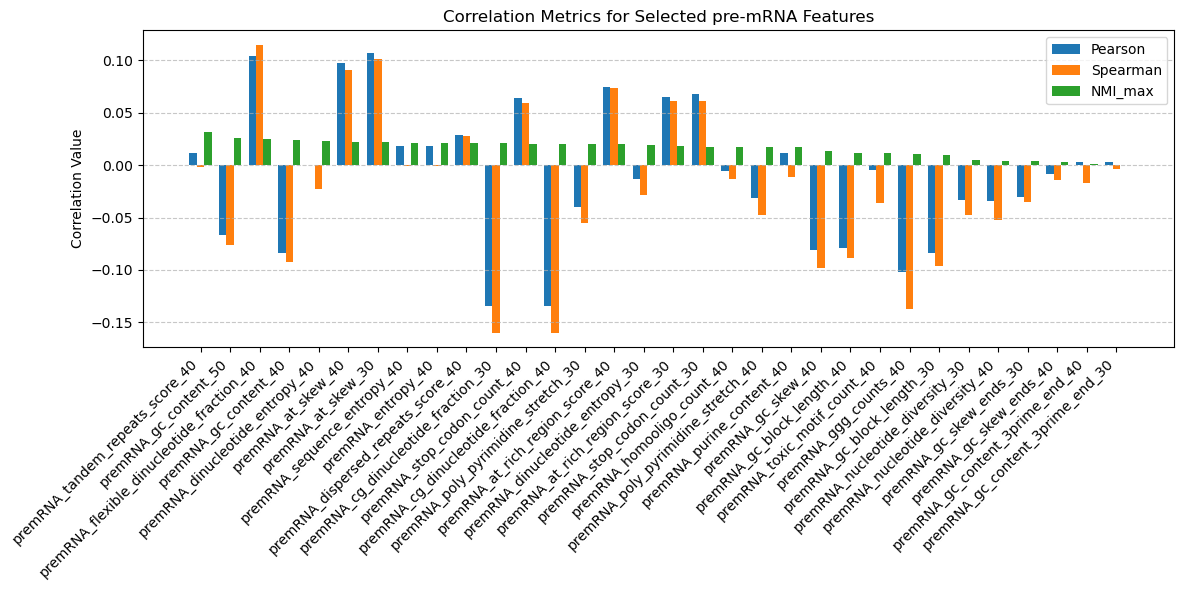

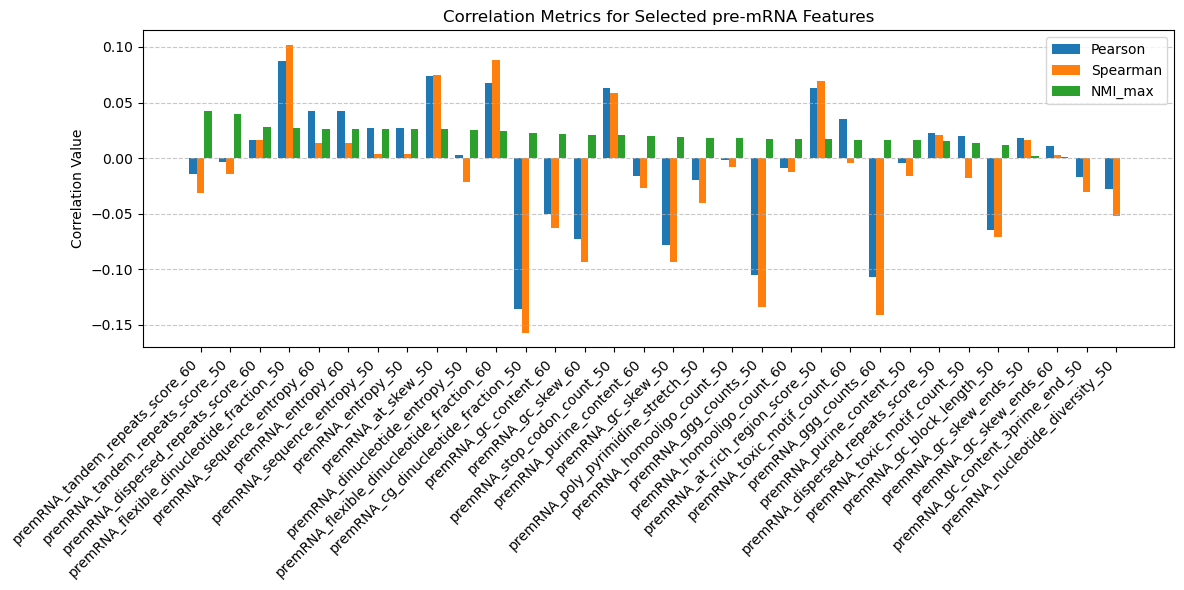

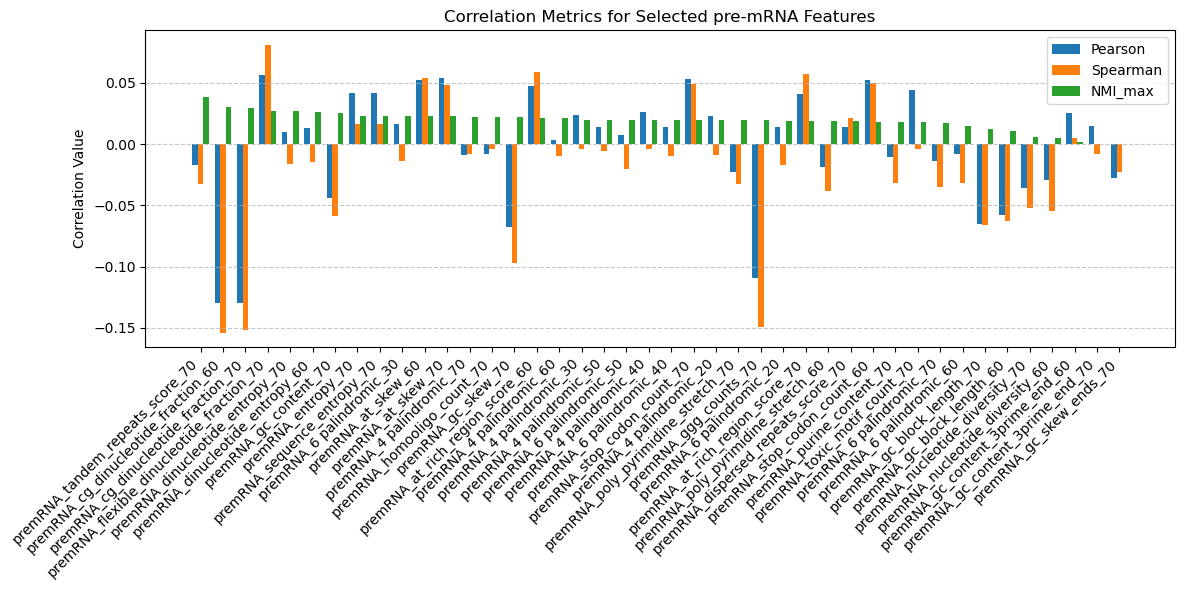

138

In [64]:
pre_mRNA_features = [col for col in filtered.columns if col.startswith("premRNA")]
plot_selected_feature_correlations_from_list(results_df, pre_mRNA_features[:32], sort_by='NMI_max', title="Correlation Metrics for Selected pre-mRNA Features")
plot_selected_feature_correlations_from_list(results_df, pre_mRNA_features[32:64], sort_by='NMI_max', title="Correlation Metrics for Selected pre-mRNA Features")
plot_selected_feature_correlations_from_list(results_df, pre_mRNA_features[64:96], sort_by='NMI_max', title="Correlation Metrics for Selected pre-mRNA Features")
plot_selected_feature_correlations_from_list(results_df, pre_mRNA_features[96:], sort_by='NMI_max', title="Correlation Metrics for Selected pre-mRNA Features")
len(pre_mRNA_features)

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

X_G = filtered[['Treatment_Period(hours)', 'ASO_volume(nM)']]
y_log = filtered["log_inhibition"]

#spliting the data to train set and validation set
X_train , X_val ,y_train , y_val = train_test_split(X_G ,y_log, test_size=0.2, random_state=42)

# building the linear regression model# 3. Train Linear Regression model on training data
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

# 4. Predict on validation data
y_pred_val = model_lin.predict(X_val)

# 5. Compute evaluation metrics
r2_val = r2_score(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
residuals_val = y_val - y_pred_val  # for next stage (e.g., sequence model)

# 6. Display results
print("=== Linear Regression on G (time + volume) ===")
print(f"R² on validation:  {r2_val:.4f}")
print(f"MAE on validation: {mae_val:.4f}")



=== Linear Regression on G (time + volume) ===
R² on validation:  0.1088
MAE on validation: 0.5117


Using a linear regression model with only Treatment_Period(hours) and ASO_volume(nM) to predict log_inhibition yielded modest results, with an R² of 0.103 and a mean absolute error (MAE) of 0.534. This means that the linear model was able to explain only about 10% of the variability in the inhibition outcome, suggesting that either the relationship between these experimental conditions and ASO effectiveness is nonlinear, or that these features alone are not sufficient to capture the underlying biological effects. A more flexible model, such as a Random Forest, may better capture potential nonlinear interactions and improve predictive performance.

In [66]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators= 100 , random_state=42)
model_rf.fit(X_train , y_train)
y_pred_rf = model_rf.predict(X_val)
r2_rf = r2_score(y_val , y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
residuals_rf = y_val - y_pred_rf
print("=== Random Forest on G (time + volume) ===")
print(f"R² on validation: {r2_rf:.4f}")
print(f"MAE on validation : {mae_rf:.4f}")


=== Random Forest on G (time + volume) ===
R² on validation: 0.3766
MAE on validation : 0.4157


Using Treatment_Period(hours) and ASO_volume(nM) as input features, a Random Forest regression model was trained to predict log_inhibition. The model achieved an R² of 0.357 and a mean absolute error (MAE) of 0.435 on the validation set. These results indicate that experimental conditions alone explain a moderate portion of the variance in ASO efficacy, and that the relationship between these variables and inhibition is likely nonlinear. The performance of the Random Forest model highlights its strength in capturing complex patterns between treatment parameters and ASO response.

In [67]:
#generating Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create a pipeline with polynomial features + linear regression
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

# Fit to training data
poly_model.fit(X_train, y_train)

# Predict on validation data
y_pred_poly = poly_model.predict(X_val)

# Evaluate
r2_poly = r2_score(y_val, y_pred_poly)
mae_poly = mean_absolute_error(y_val, y_pred_poly)
residuals_poly = y_val - y_pred_poly

# Report
print("=== Polynomial Regression on G (time + volume) ===")
print(f"R² on validation:  {r2_poly:.4f}")
print(f"MAE on validation: {mae_poly:.4f}")


=== Polynomial Regression on G (time + volume) ===
R² on validation:  0.1479
MAE on validation: 0.4971


In [68]:
from xgboost import XGBRegressor

# Train XGBoost on training data
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

# Predict on validation data
y_pred_xgb = model_xgb.predict(X_val)

# Evaluate
r2_xgb = r2_score(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
residuals_xgb = y_val - y_pred_xgb

# Report
print("=== XGBoost on G (time + volume) ===")
print(f"R² on validation:  {r2_xgb:.4f}")
print(f"MAE on validation: {mae_xgb:.4f}")


=== XGBoost on G (time + volume) ===
R² on validation:  0.3764
MAE on validation: 0.4158


| Model                                | R² (Validation) | MAE (Validation) | Notes                                          |
| ------------------------------------ | --------------- | ---------------- | ---------------------------------------------- |
| **Linear Regression**                | 0.103           | 0.534            | Weak performance; limited explanatory power    |
| **Polynomial Regression (degree 2)** | 0.138           | 0.518            | Slight improvement, but still underwhelming    |
| **Random Forest**                    | 0.357           | 0.435            | Significant improvement; captures nonlinearity |
| **XGBoost**                          | 0.357           | 0.435            | Matches Random Forest almost exactly           |


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np

# 1. Define input (G) and target (log(y))
X_G = filtered[['Treatment_Period(hours)', 'ASO_volume(nM)']]
y_log = filtered['log_inhibition']  # already in log scale

# 2. Create array to store out-of-fold predictions (log(G))
oof_log_G = np.zeros(len(X_G))

# 3. K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Loop over folds to generate out-of-fold predictions
for train_idx, val_idx in kf.split(X_G):
    X_train, X_val = X_G.iloc[train_idx], X_G.iloc[val_idx]
    y_train = y_log.iloc[train_idx]

    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    oof_log_G[val_idx] = model_rf.predict(X_val)

# 5. Compute log(M) = log(y) - log(G)
log_M = y_log - oof_log_G

# Optional: quick sanity check
print(f"log(G) min: {oof_log_G.min():.4f}, max: {oof_log_G.max():.4f}")
print(f"log(M) first 5 values: {log_M.head().round(4).tolist()}")


log(G) min: -4.5656, max: -2.0146
log(M) first 5 values: [-0.7871, -1.1338, -0.2645, -0.8591, -0.7413]


In [70]:
filtered["log_inhibition_residual"] = log_M
#filtered_correlations_df = analyze_feature_correlations(filtered, target='log_inhibition')

creating the new df without the treatment period and the volume

In [71]:
unclean_new_filtered = filtered.copy()
drop_columns = ['log_inhibition','Treatment_Period(hours)', 'ASO_volume(nM)',"Inhibition(%)","log_volume"]
unclean_new_filtered = unclean_new_filtered.drop(columns = drop_columns)

groups rows that have the same values across all non-target columns

In [72]:

# Step 1: Specify the value columns to aggregate
value_columns_new = ["log_inhibition_residual"]

# Step 2: Create a grouping key from all other columns
unclean_new_filtered['_merge_key'] = (
    unclean_new_filtered
    .drop(columns=value_columns_new)
    .astype(str)
    .agg('_'.join, axis=1)
)

# Step 3: Group by that key and calculate mean of the value columns
new_agg_result = unclean_new_filtered.groupby('_merge_key', as_index=False)[value_columns_new].mean()

# Step 4: Drop duplicates and join back the original context
new_dedup_context = unclean_new_filtered.drop_duplicates('_merge_key').drop(columns=value_columns_new)
new_filtered = pd.merge(new_dedup_context, new_agg_result, on='_merge_key').drop(columns=['_merge_key'])

In [73]:
new_results_df = analyze_feature_correlations(new_filtered, target="log_inhibition_residual")
display(new_results_df)


/tmp/ipykernel_2173189/3995343351.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/tmp/ipykernel_2173189/3995343351.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


,Feature,Pearson,Spearman,NMI_max
0,ISIS,0.005,0.130,0.630
83,tAI_score_global_CDS,0.115,0.107,0.457
76,ENC_score_global_CDS,-0.158,-0.182,0.421
2,Density(cells/well),0.112,0.161,0.326
263,log_density,0.109,0.161,0.324
...,...,...,...,...
8,Linkage_Location,NaN,NaN,NaN
9,Smiles,NaN,NaN,NaN
11,Canonical Gene Name,NaN,NaN,NaN
12,Cell line organism,NaN,NaN,NaN


Global CDS features:


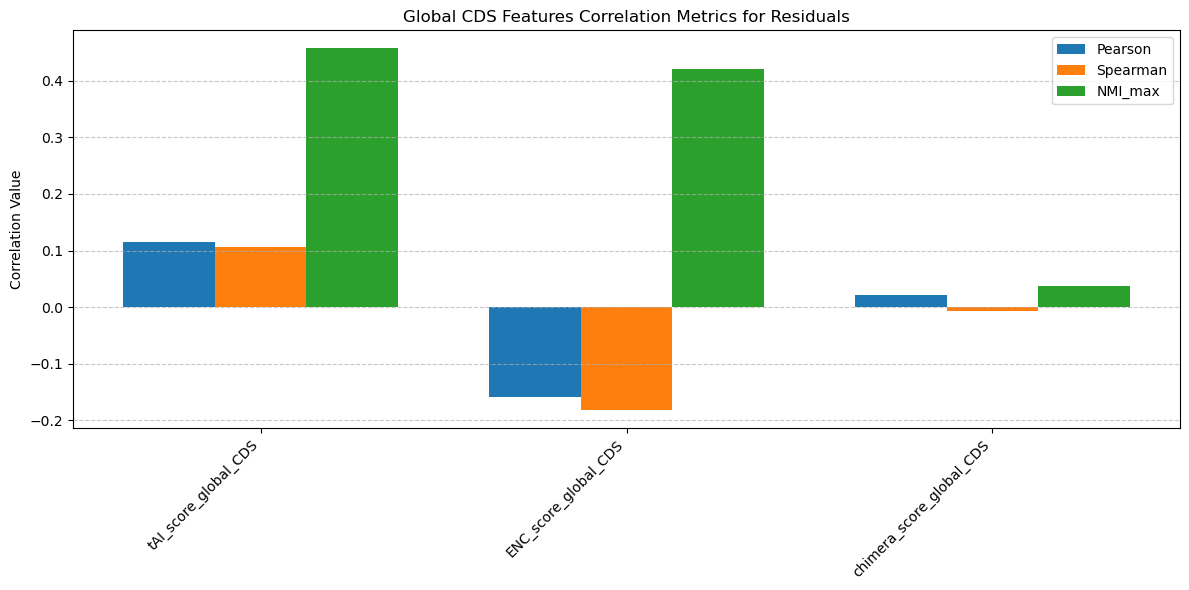

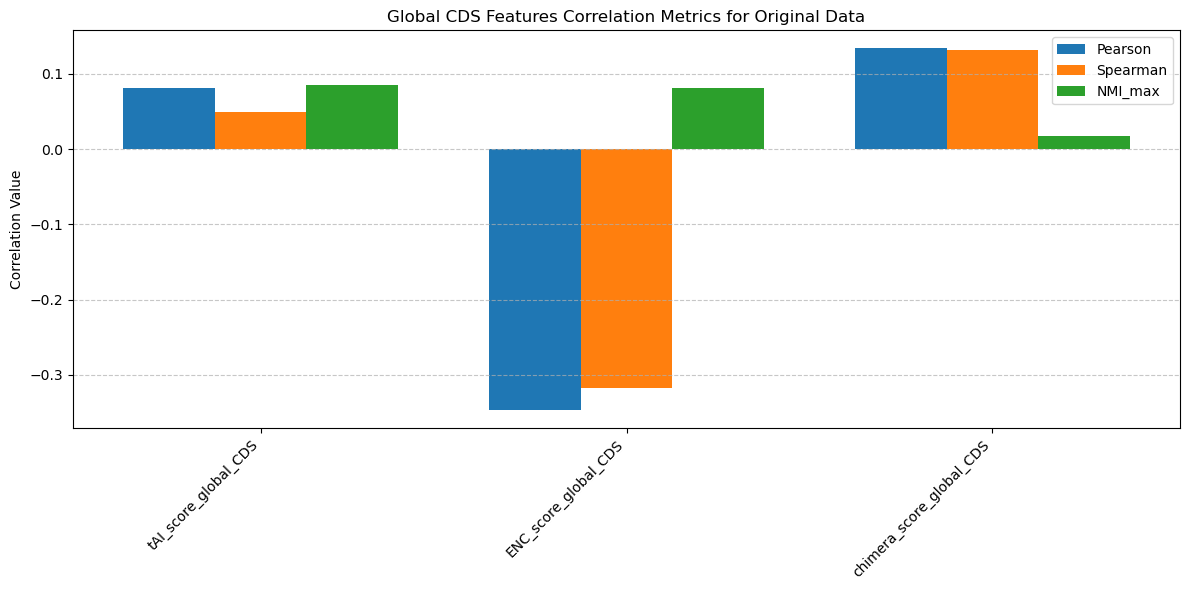

In [74]:
new_mask = ~new_results_df["Feature"].str.endswith("_global_CDS")
new_results_df_without_global = new_results_df[new_mask]
new_suffix = "score_global_CDS"
new_global_result_df = new_results_df[new_results_df['Feature'].str.endswith(new_suffix)]

print("Global CDS features:")
plot_feature_correlations_by_prefix(new_global_result_df, prefix='', title="Global CDS Features Correlation Metrics for Residuals")
plot_feature_correlations_by_prefix(global_result_df, prefix='', title="Global CDS Features Correlation Metrics for Original Data")


In [75]:
enc_columns = [col for col in new_filtered.columns if col.startswith("ENC_score")]
enc_columns.remove("ENC_score_global_CDS")  # Remove global CDS if present
missing_info = new_filtered[enc_columns].isna().sum().to_frame(name="NaN count")
missing_info["% missing"] = (missing_info["NaN count"] / len(new_filtered) * 100).round(2)
print(missing_info)


              NaN count  % missing
ENC_score_20          0        0.0
ENC_score_30          0        0.0
ENC_score_40          0        0.0
ENC_score_50          0        0.0
ENC_score_60          0        0.0
ENC_score_70          0        0.0


In [76]:
tai_columns = [col for col in new_filtered.columns if col.startswith("tAI_score")] 
tai_columns.remove("tAI_score_global_CDS")
tai_missing_info = new_filtered[tai_columns].isna().sum().to_frame(name="NaN count")
tai_missing_info["% missing"] = (tai_missing_info["NaN count"] / len(new_filtered) * 100).round(2)

print(tai_missing_info)


              NaN count  % missing
tAI_score_20      12898      66.34
tAI_score_30      12898      66.34
tAI_score_40      12898      66.34
tAI_score_50      12898      66.34
tAI_score_60      12898      66.34
tAI_score_70      12898      66.34


In [77]:
chimera_columns = [col for col in new_filtered.columns if col.startswith('chimera_score_CDS')]
chimera_missing_info = new_filtered[chimera_columns].isna().sum().to_frame(name="NaN count")
chimera_missing_info["% missing"] = (chimera_missing_info["NaN count"] / len(new_filtered) * 100).round(2)
print(chimera_missing_info)

                      NaN count  % missing
chimera_score_CDS_20      12898      66.34
chimera_score_CDS_30      12898      66.34
chimera_score_CDS_40      12898      66.34
chimera_score_CDS_50      12898      66.34
chimera_score_CDS_60      12898      66.34
chimera_score_CDS_70      12898      66.34


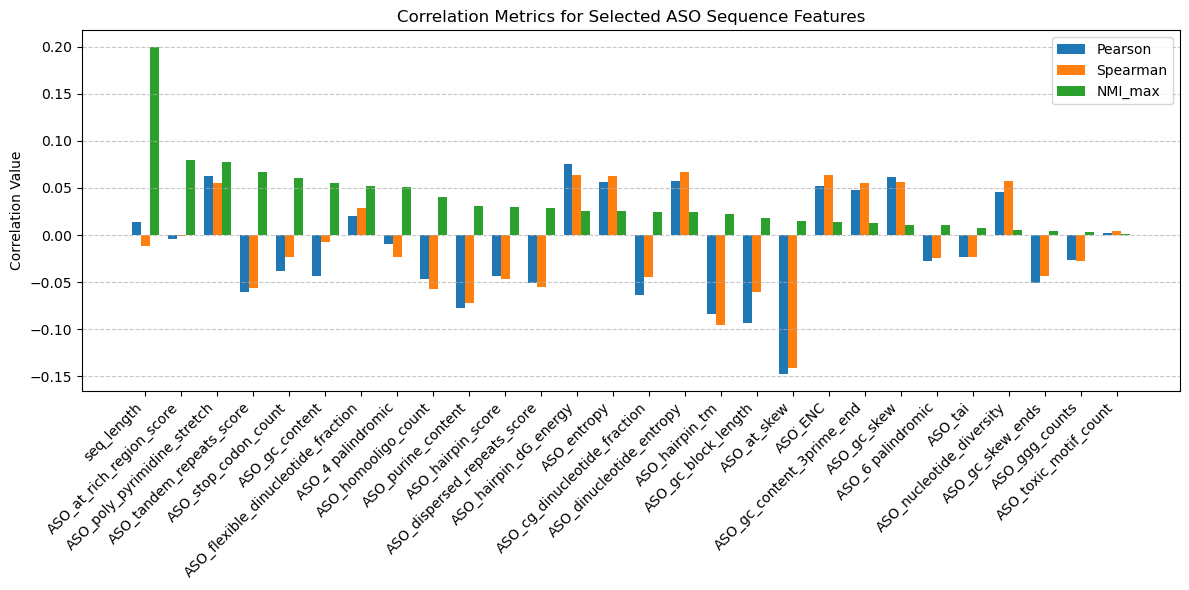

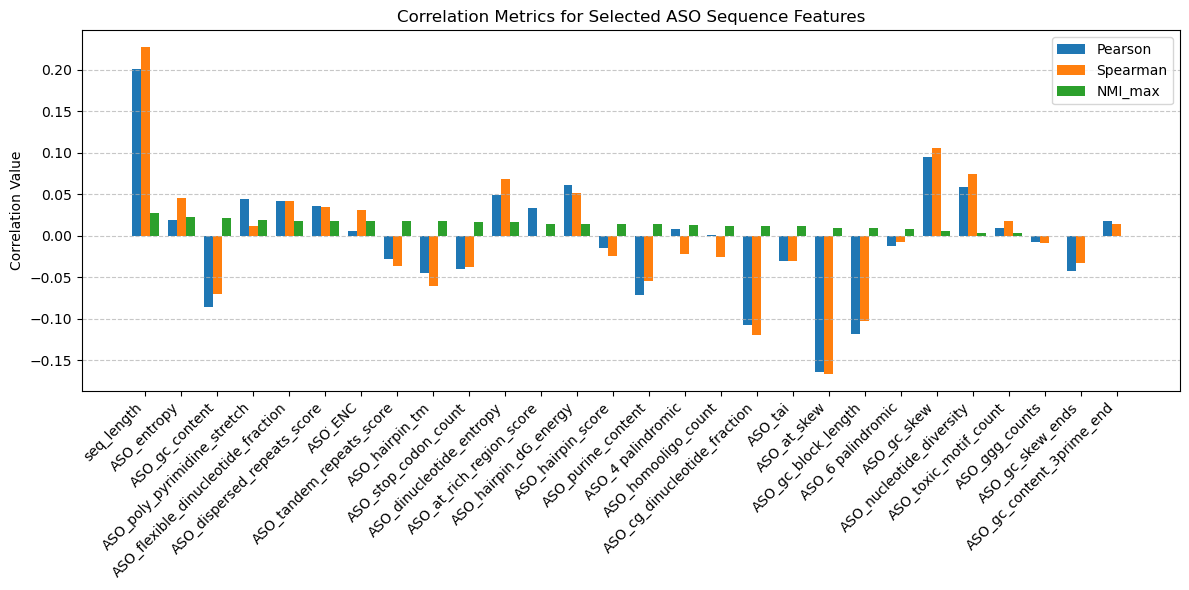

In [78]:

plot_selected_feature_correlations_from_list(new_results_df, aso_seq_features, sort_by='NMI_max', title="Correlation Metrics for Selected ASO Sequence Features")
plot_selected_feature_correlations_from_list(results_df, aso_seq_features, sort_by='NMI_max', title="Correlation Metrics for Selected ASO Sequence Features")


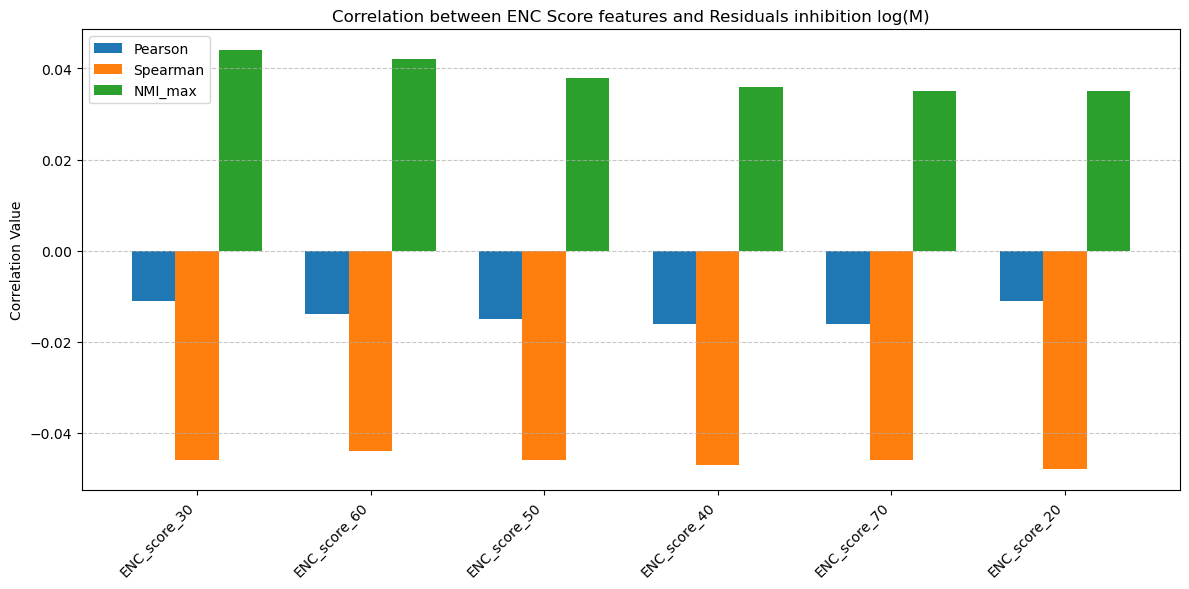

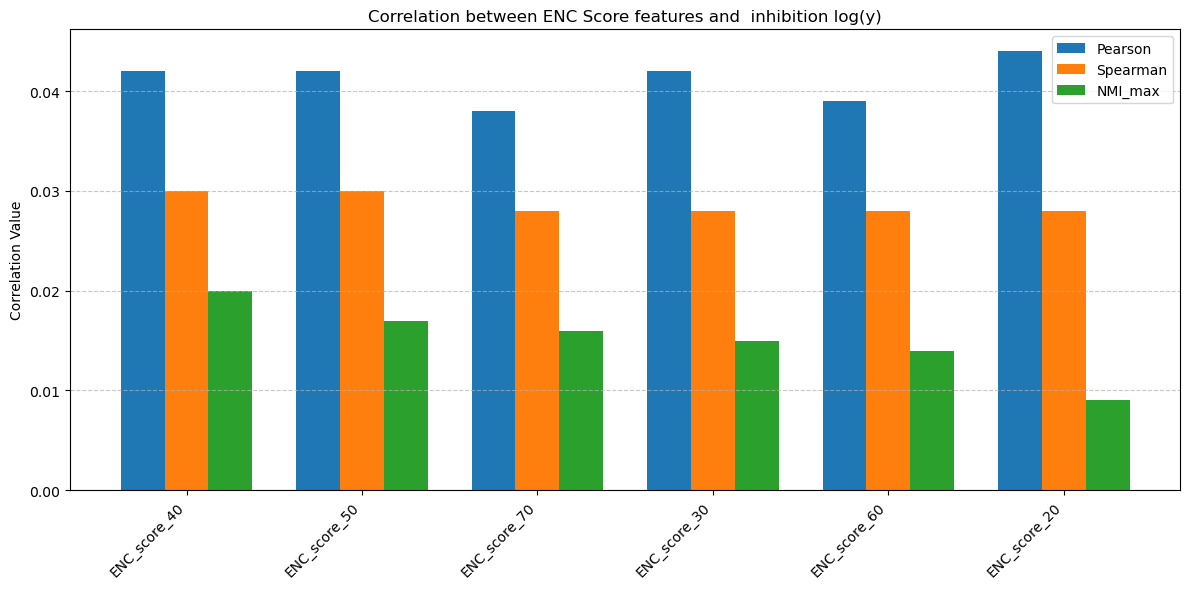

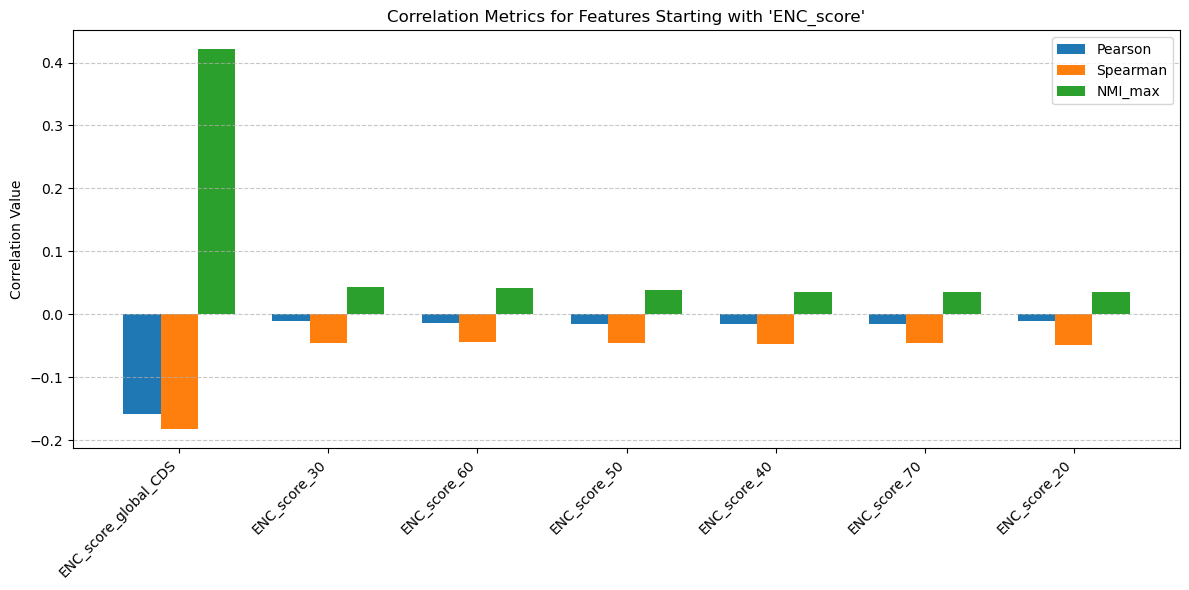

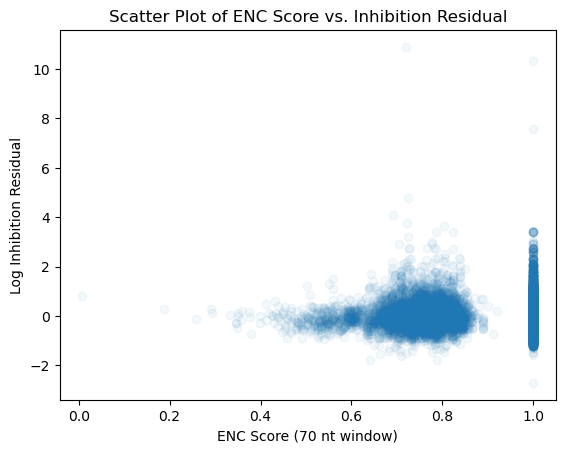

In [79]:
#ENC_score features
plot_feature_correlations_by_prefix(new_results_df_without_global, prefix='ENC_score',title="Correlation between ENC Score features and Residuals inhibition log(M)")
plot_feature_correlations_by_prefix(results_df_without_global, prefix='ENC_score',  title="Correlation between ENC Score features and  inhibition log(y)" )
plot_feature_correlations_by_prefix(new_results_df, prefix='ENC_score')


plt.scatter(new_filtered['ENC_score_70'], new_filtered["log_inhibition_residual"], alpha=0.05)
plt.xlabel("ENC Score (70 nt window)")
plt.ylabel("Log Inhibition Residual")
plt.title("Scatter Plot of ENC Score vs. Inhibition Residual")
plt.show()

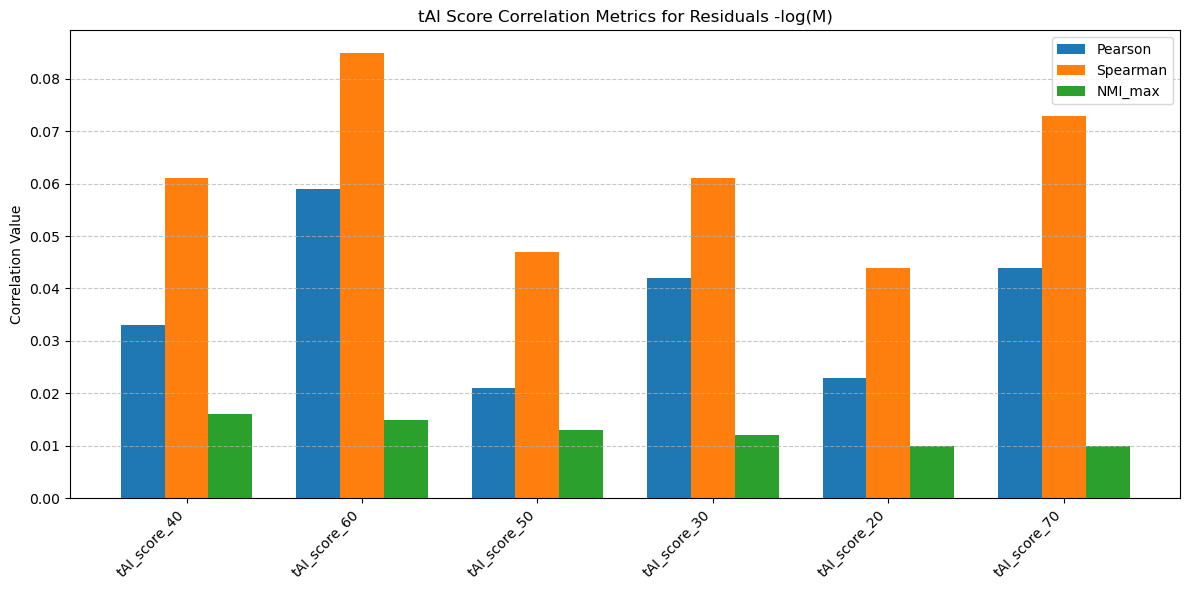

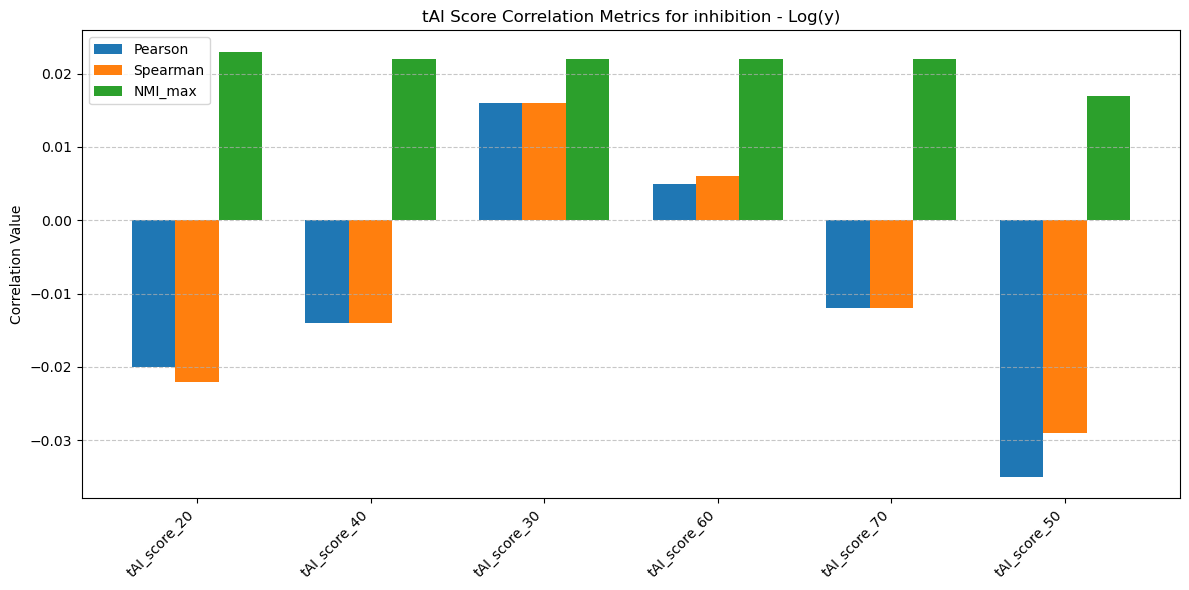

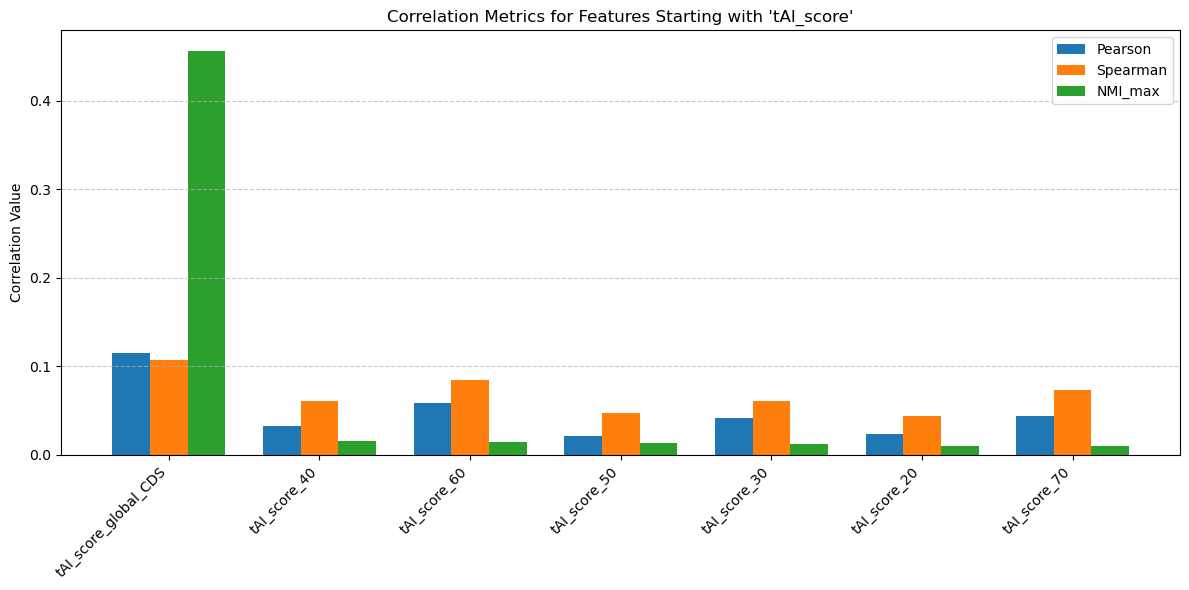

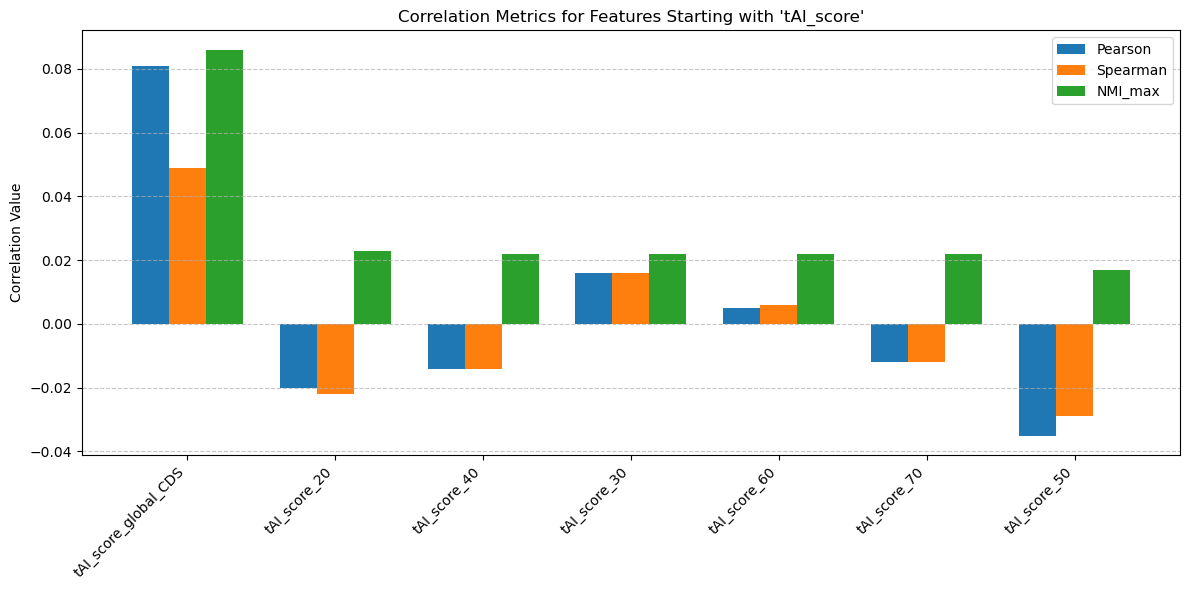

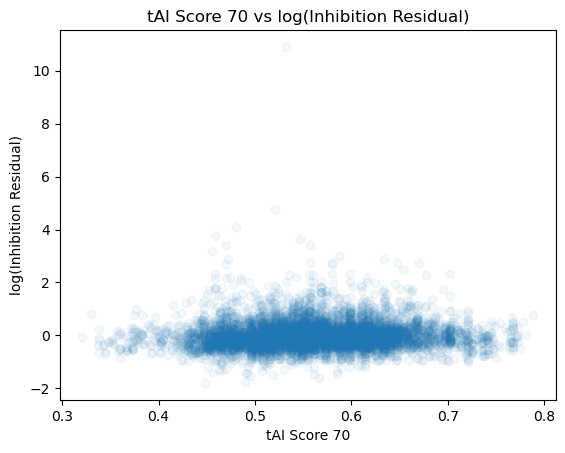

In [80]:
plot_feature_correlations_by_prefix(new_results_df_without_global, prefix='tAI_score', title="tAI Score Correlation Metrics for Residuals -log(M)")
plot_feature_correlations_by_prefix(results_df_without_global, prefix='tAI_score', title="tAI Score Correlation Metrics for inhibition - Log(y)")
plot_feature_correlations_by_prefix(new_results_df, prefix='tAI_score')
plot_feature_correlations_by_prefix(results_df, prefix='tAI_score')



plt.scatter(new_filtered["tAI_score_70"], new_filtered["log_inhibition_residual"],alpha=0.05)
plt.xlabel("tAI Score 70")
plt.ylabel("log(Inhibition Residual)")
plt.title("tAI Score 70 vs log(Inhibition Residual)")
plt.show()


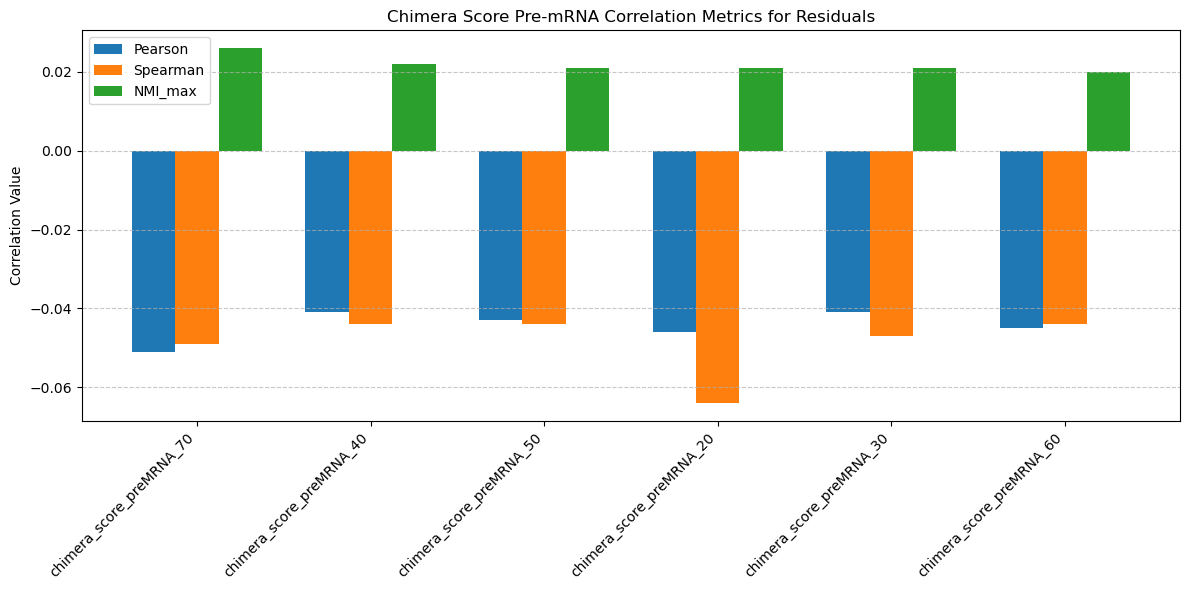

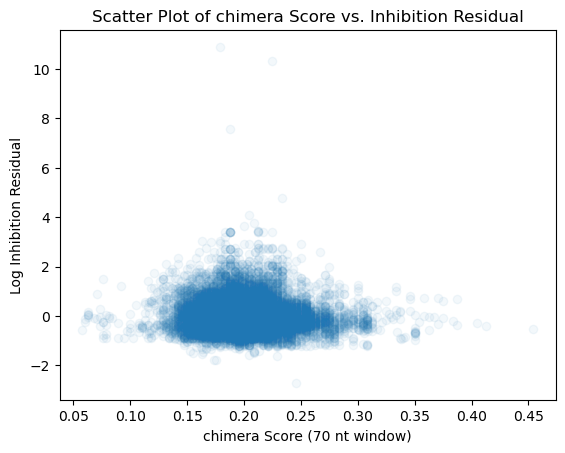

In [81]:
plot_feature_correlations_by_prefix(new_results_df_without_global, prefix='chimera_score_preMRNA', title="Chimera Score Pre-mRNA Correlation Metrics for Residuals")

plt.scatter(new_filtered['chimera_score_preMRNA_70'], new_filtered["log_inhibition_residual"], alpha=0.05)
plt.xlabel("chimera Score (70 nt window)")
plt.ylabel("Log Inhibition Residual")
plt.title("Scatter Plot of chimera Score vs. Inhibition Residual")
plt.show()

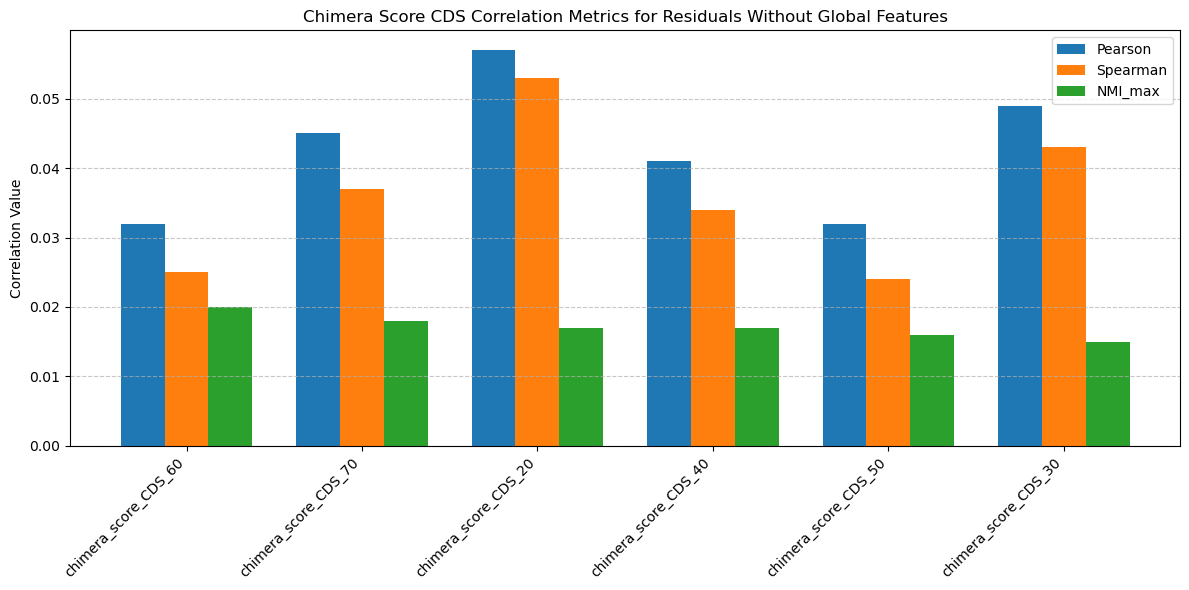

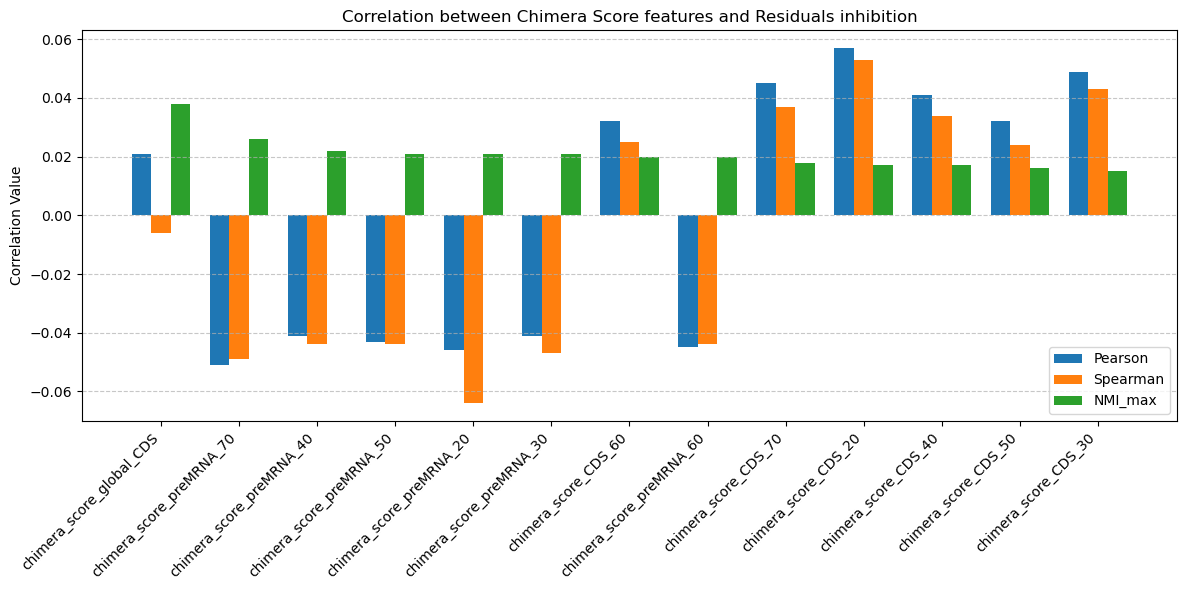

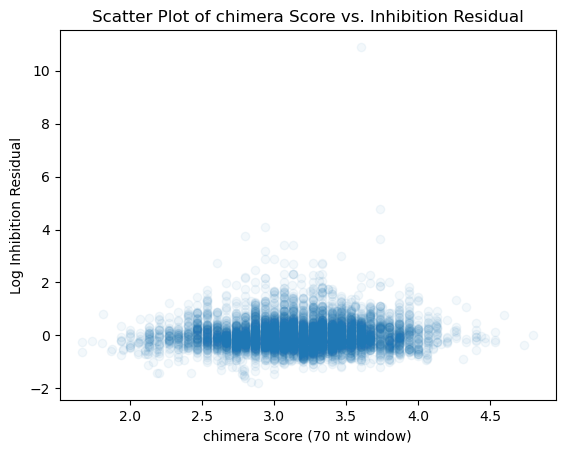

In [82]:
plot_feature_correlations_by_prefix(new_results_df_without_global, prefix='chimera_score_CDS', title="Chimera Score CDS Correlation Metrics for Residuals Without Global Features")
plot_feature_correlations_by_prefix(new_results_df, prefix='chimera_score', title="Correlation between Chimera Score features and Residuals inhibition")

plt.scatter(new_filtered['chimera_score_CDS_70'], new_filtered["log_inhibition_residual"], alpha=0.05)
plt.xlabel("chimera Score (70 nt window)")
plt.ylabel("Log Inhibition Residual")
plt.title("Scatter Plot of chimera Score vs. Inhibition Residual")
plt.show()


Plot modification features correlation to log(M)

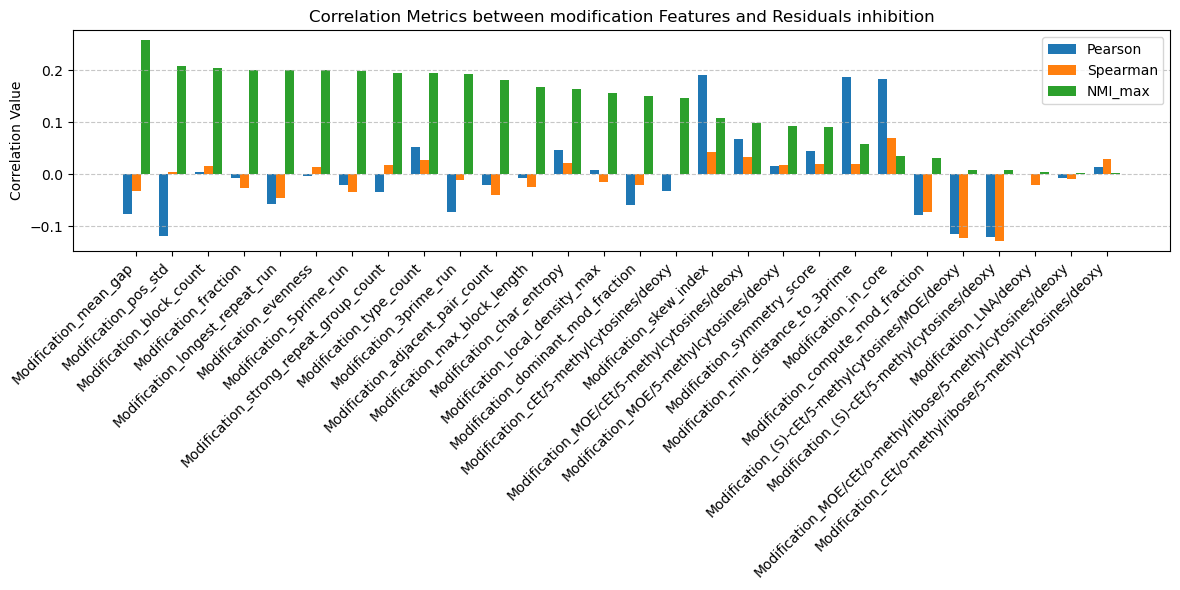

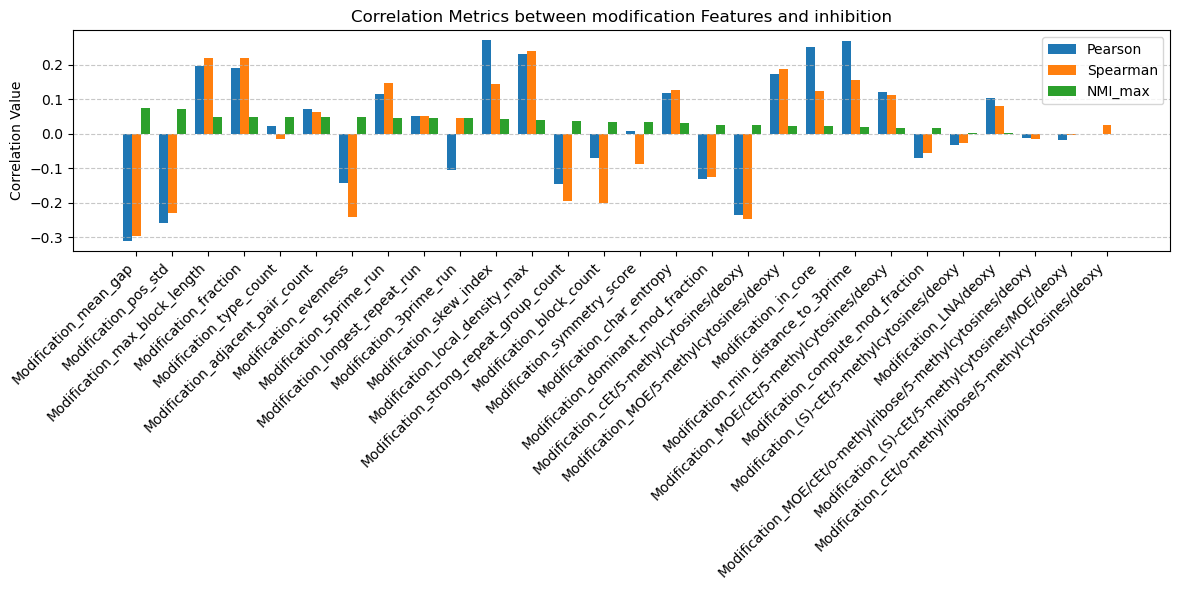

In [100]:
modification_features = [col for col in new_filtered.columns if col.startswith("Modification_")]
plot_selected_feature_correlations_from_list(new_results_df, modification_features, sort_by='NMI_max', title="Correlation Metrics between modification Features and Residuals inhibition")
plot_selected_feature_correlations_from_list(results_df, modification_features, sort_by='NMI_max', title="Correlation Metrics between modification Features and inhibition")

In [84]:

# Column names and their purpose
SENSE_START = 'sense_start'               # Genomic index of ASO binding site in pre-mRNA
SENSE_LENGTH = 'sense_length'             # Length of the ASO (in nucleotides)
SENSE_TYPE = 'sense_type'                 # Whether the binding site falls in an exon or intron
CDS_SEQUENCE = 'cds_sequence'             # Full coding region (CDS) of the gene
IN_CODING_REGION = 'in_coding_region'     # Whether the ASO binds inside the CDS on a real exon

ONE_HOT_FEATURE_NAMES = [CELL_LINE, TRANSFECTION, MODIFICATION , SENSE_TYPE]
# more feature generation
feature_base = [SENSE_START, SENSE_LENGTH]
experiment_features = [ 'log_density']

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])

# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]
start_list = ['chimera_score_','tAI_score', 'ENC_score']
cds_and_premRNA_features = [feature for feature in filtered.columns if any(start in feature for start in start_list)]

#features = feature_base + experiment_features + flat_one_hot_encoded_features + aso_seq_features + cds_and_premRNA_features + pre_mRNA_features + modification_features

features = list(dict.fromkeys(feature_base + experiment_features + flat_one_hot_encoded_features + aso_seq_features + cds_and_premRNA_features + pre_mRNA_features + modification_features))



In [85]:
"""""
from sklearn.preprocessing import StandardScaler

# Define flank sizes (e.g., [20, 30, 40, 50, 60, 70])
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

# Feature base names to normalize
FEATURE_BASE_NAMES = ["ENC_score", "tAI_score", "chimera_score_CDS"]

# Loop over flank sizes and normalize local/global separately
for flank in CDS_WINDOWS:
    local_mask = new_filtered[f"region_is_local_{flank}"] == 1
    global_mask = ~local_mask

    for base_feature in FEATURE_BASE_NAMES:
        col_name = f"{base_feature}_{flank}"

        # Normalize local
        if new_filtered.loc[local_mask, col_name].notna().sum() > 0:
            scaler_local = StandardScaler()
            new_filtered.loc[local_mask, col_name] = scaler_local.fit_transform(
                new_filtered.loc[local_mask, [col_name]]
            )

        # Normalize global
        if new_filtered.loc[global_mask, col_name].notna().sum() > 0:
            scaler_global = StandardScaler()
            new_filtered.loc[global_mask, col_name] = scaler_global.fit_transform(
                new_filtered.loc[global_mask, [col_name]]
            )
"""

'""\nfrom sklearn.preprocessing import StandardScaler\n\n# Define flank sizes (e.g., [20, 30, 40, 50, 60, 70])\nCDS_WINDOWS = [20, 30, 40, 50, 60, 70]\n\n# Feature base names to normalize\nFEATURE_BASE_NAMES = ["ENC_score", "tAI_score", "chimera_score_CDS"]\n\n# Loop over flank sizes and normalize local/global separately\nfor flank in CDS_WINDOWS:\n    local_mask = new_filtered[f"region_is_local_{flank}"] == 1\n    global_mask = ~local_mask\n\n    for base_feature in FEATURE_BASE_NAMES:\n        col_name = f"{base_feature}_{flank}"\n\n        # Normalize local\n        if new_filtered.loc[local_mask, col_name].notna().sum() > 0:\n            scaler_local = StandardScaler()\n            new_filtered.loc[local_mask, col_name] = scaler_local.fit_transform(\n                new_filtered.loc[local_mask, [col_name]]\n            )\n\n        # Normalize global\n        if new_filtered.loc[global_mask, col_name].notna().sum() > 0:\n            scaler_global = StandardScaler()\n            new

Implement the model without the region features 

In [86]:
remove_list = tai_columns + enc_columns + chimera_columns
train, test = train_test_split(new_filtered, test_size=0.2)
X_train = train[features]
X_train = X_train.drop(columns=remove_list, errors='ignore')
y_train = train["log_inhibition_residual"]
X_val = test[features]
X_val = X_val.drop(columns=remove_list, errors='ignore')
y_val = test["log_inhibition_residual"]


=== XGBoost ===
Train MAE:     0.123
Validation MAE:0.267
Train Pearson: 0.958
Val Pearson:   0.736
Train Spearman:0.943
Val Spearman:  0.705
Top features:
Modification_min_distance_to_3prime    0.074268
tAI_score_global_CDS                   0.070226
premRNA_gc_block_length_20             0.039433
Cell_line_HepaRG                       0.031885
premRNA_gc_block_length_40             0.020644
Cell_line_SNU-449                      0.015221
ASO_gc_block_length                    0.014212
ENC_score_global_CDS                   0.013823
premRNA_cg_dinucleotide_fraction_70    0.012869
ASO_homooligo_count                    0.011535
Cell_line_A431                         0.010772
sense_type_exon                        0.010537
premRNA_ggg_counts_40                  0.010253
Transfection_free uptake               0.010080
Modification_skew_index                0.009980
premRNA_gc_block_length_70             0.009632
ASO_at_skew                            0.009421
premRNA_cg_dinucleotide_frac

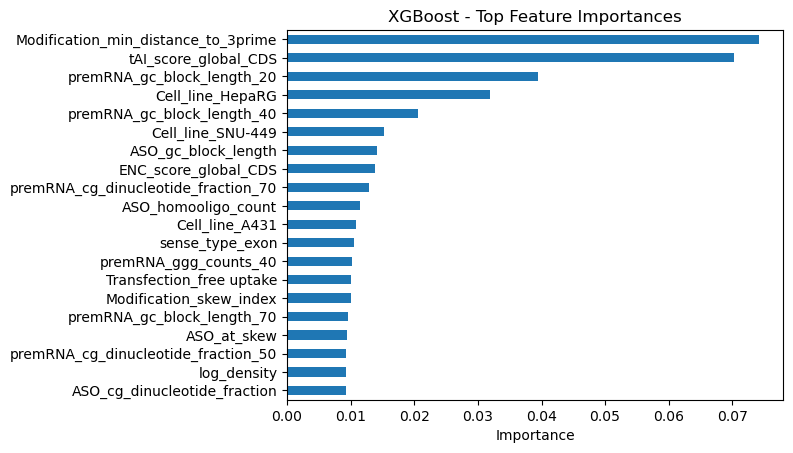

In [87]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, random_state=42)
xgb.fit(X_train, y_train)

train_pred = xgb.predict(X_train)
val_pred = xgb.predict(X_val)

print("=== XGBoost ===")
print(f"Train MAE:     {mean_absolute_error(y_train, train_pred):.3f}")
print(f"Validation MAE:{mean_absolute_error(y_val, val_pred):.3f}")
print(f"Train Pearson: {pearsonr(y_train, train_pred)[0]:.3f}")
print(f"Val Pearson:   {pearsonr(y_val, val_pred)[0]:.3f}")
print(f"Train Spearman:{spearmanr(y_train, train_pred)[0]:.3f}")
print(f"Val Spearman:  {spearmanr(y_val, val_pred)[0]:.3f}")

xgb_importance = pd.Series(xgb.feature_importances_, index=X_train.columns)
top_xgb = xgb_importance.sort_values(ascending=False).head(20)
print("Top features:")
print(top_xgb)

top_xgb.plot(kind='barh')
plt.title("XGBoost - Top Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

In [88]:
xgb_importance.sort_values(ascending=False).head(40)

Modification_min_distance_to_3prime          0.074268
tAI_score_global_CDS                         0.070226
premRNA_gc_block_length_20                   0.039433
Cell_line_HepaRG                             0.031885
premRNA_gc_block_length_40                   0.020644
Cell_line_SNU-449                            0.015221
ASO_gc_block_length                          0.014212
ENC_score_global_CDS                         0.013823
premRNA_cg_dinucleotide_fraction_70          0.012869
ASO_homooligo_count                          0.011535
Cell_line_A431                               0.010772
sense_type_exon                              0.010537
premRNA_ggg_counts_40                        0.010253
Transfection_free uptake                     0.010080
Modification_skew_index                      0.009980
premRNA_gc_block_length_70                   0.009632
ASO_at_skew                                  0.009421
premRNA_cg_dinucleotide_fraction_50          0.009333
log_density                 

implement the model without cell line and transfection features

In [89]:
cell_line_drop_list =[ col for col in new_filtered.columns if col.startswith("Cell_line_") ]
transfection_drop_list = [col for col in new_filtered.columns if col.startswith("Transfection_")]

remove_list_with_cell = tai_columns + enc_columns + chimera_columns + cell_line_drop_list + transfection_drop_list
train_without_cell, test_without_cell = train_test_split(new_filtered, test_size=0.2)
X_train_without_cell = train_without_cell[features]
X_train_without_cell = X_train_without_cell.drop(columns=remove_list_with_cell, errors='ignore')
Y_train_without_cell = train_without_cell["log_inhibition_residual"]
X_val_without_cell = test_without_cell[features]
X_val_without_cell = X_val_without_cell.drop(columns=remove_list_with_cell, errors='ignore')
y_val_without_cell = test_without_cell["log_inhibition_residual"]


=== XGBoost ===
Train MAE:     0.121
Validation MAE:0.269
Train Pearson: 0.958
Val Pearson:   0.739
Train Spearman:0.944
Val Spearman:  0.727
Top features without cell and transfection:
Modification_min_distance_to_3prime          0.134942
tAI_score_global_CDS                         0.070081
premRNA_cg_dinucleotide_fraction_50          0.040046
premRNA_gc_block_length_20                   0.023935
premRNA_cg_dinucleotide_fraction_70          0.016436
premRNA_gc_block_length_40                   0.016066
premRNA_toxic_motif_count_70                 0.014602
ENC_score_global_CDS                         0.014026
Modification_LNA/deoxy                       0.011806
Modification_longest_repeat_run              0.011281
premRNA_gc_block_length_50                   0.010918
premRNA_flexible_dinucleotide_fraction_70    0.010886
ASO_homooligo_count                          0.010838
log_density                                  0.009810
premRNA_ggg_counts_30                        0.009304
prem

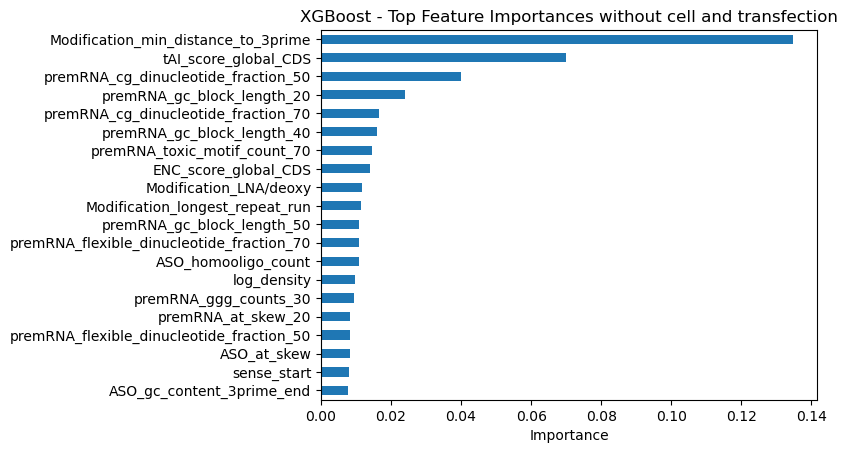

In [90]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, random_state=42)
xgb.fit(X_train_without_cell, Y_train_without_cell)

train_pred_without_cell = xgb.predict(X_train_without_cell)
val_pred_without_cell = xgb.predict(X_val_without_cell)

print("=== XGBoost ===")
print(f"Train MAE:     {mean_absolute_error(Y_train_without_cell, train_pred_without_cell):.3f}")
print(f"Validation MAE:{mean_absolute_error(y_val_without_cell, val_pred_without_cell):.3f}")
print(f"Train Pearson: {pearsonr(Y_train_without_cell, train_pred_without_cell)[0]:.3f}")
print(f"Val Pearson:   {pearsonr(y_val_without_cell, val_pred_without_cell)[0]:.3f}")
print(f"Train Spearman:{spearmanr(Y_train_without_cell, train_pred_without_cell)[0]:.3f}")
print(f"Val Spearman:  {spearmanr(y_val_without_cell, val_pred_without_cell)[0]:.3f}")

xgb_importance_without_cell = pd.Series(xgb.feature_importances_, index=X_train_without_cell.columns)
top_xgb_without_cell = xgb_importance_without_cell.sort_values(ascending=False).head(20)
print("Top features without cell and transfection:")
print(top_xgb_without_cell)

top_xgb_without_cell.plot(kind='barh')
plt.title("XGBoost - Top Feature Importances without cell and transfection")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

lets seperate the data to global and local

In [91]:
flank = 50  # or any other flank size you're working with

# Column indicating if the region is local (1) or not (0)
local_flag_col = f"region_is_local_{flank}"

# Ensure the flag exists
assert local_flag_col in new_filtered.columns, f"{local_flag_col} not found in new_filtered"

# Split the dataset
local_df = new_filtered[new_filtered[local_flag_col] == 1].copy()
global_df = new_filtered[new_filtered[local_flag_col] == 0].copy()

print(f"✅ Local samples: {len(local_df)}")
print(f"✅ Global samples: {len(global_df)}")


✅ Local samples: 6543
✅ Global samples: 12898


In [92]:
flank = 70
local_mask = new_filtered[f"region_is_local_{flank}"] == 1
global_mask = ~local_mask

# Define the target column
target_col = "log_inhibition_residual"

# Separate feature columns

local_feature_cols = features
global_feature_cols = [col for col in features if col not in remove_list]

# Create X and y for each subset
X_local = new_filtered[local_mask][local_feature_cols]
y_local = new_filtered[local_mask][target_col]

X_global = new_filtered[global_mask][global_feature_cols]
y_global = new_filtered[global_mask][target_col]

print("✅ Local feature shape:", X_local.shape)
print("✅ Global feature shape:", X_global.shape)

✅ Local feature shape: (6543, 245)
✅ Global feature shape: (12898, 227)


In [93]:
from sklearn.model_selection import train_test_split

# Local train/test split
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
    X_local, y_local, test_size=0.2, random_state=42
)

# Global train/test split
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_global, y_global, test_size=0.2, random_state=42
)


In [94]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Local model
model_local = XGBRegressor(n_estimators=100, random_state=42)
model_local.fit(X_train_local, y_train_local)
y_pred_local = model_local.predict(X_test_local)

# Global model
model_global = XGBRegressor(n_estimators=100, random_state=42)
model_global.fit(X_train_global, y_train_global)
y_pred_global = model_global.predict(X_test_global)


In [95]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import numpy as np

def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    print(f"📊 Results for {label} subset:")
    print(f"  ➤ RMSE:         {rmse:.3f}")
    print(f"  ➤ MAE:          {mae:.3f}")
    print(f"  ➤ R² Score:     {r2:.3f}")
    print(f"  ➤ Pearson r:    {pearson_corr:.3f}")
    print(f"  ➤ Spearman ρ:   {spearman_corr:.3f}")
    print("-" * 50)

evaluate_model(y_test_local, y_pred_local, "Local")
evaluate_model(y_test_global, y_pred_global, "Global")


📊 Results for Local subset:
  ➤ RMSE:         0.350
  ➤ MAE:          0.250
  ➤ R² Score:     0.525
  ➤ Pearson r:    0.728
  ➤ Spearman ρ:   0.707
--------------------------------------------------
📊 Results for Global subset:
  ➤ RMSE:         0.390
  ➤ MAE:          0.281
  ➤ R² Score:     0.557
  ➤ Pearson r:    0.747
  ➤ Spearman ρ:   0.723
--------------------------------------------------



🔎 Feature Importance - Local Model:
                                                    Feature  Importance
                                             Cell_line_U251    0.058093
                                      premRNA_gc_content_50    0.050296
                                       ENC_score_global_CDS    0.045423
                                      premRNA_gc_content_70    0.036357
                                        ASO_homooligo_count    0.034960
                                               sense_length    0.027528
                        premRNA_cg_dinucleotide_fraction_70    0.026220
                  premRNA_flexible_dinucleotide_fraction_60    0.022063
                                 premRNA_gc_block_length_60    0.020493
                                      premRNA_gc_content_30    0.018682
                                   premRNA_6 palindromic_20    0.015720
                                 premRNA_gc_block_length_50    0.015686
                           

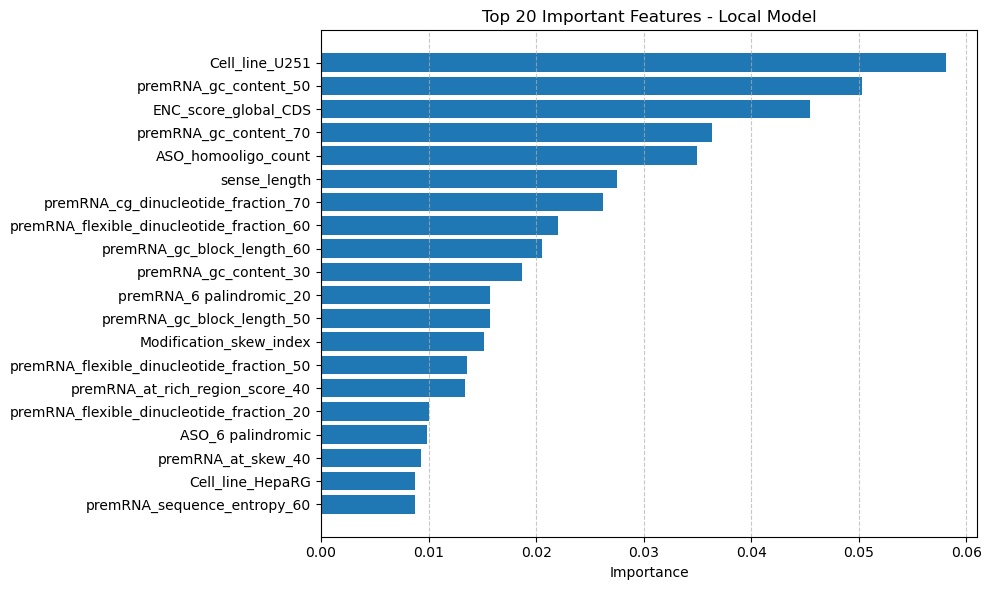


🔎 Feature Importance - Global Model:
                                                    Feature  Importance
                                       ENC_score_global_CDS    0.149873
                        Modification_min_distance_to_3prime    0.067226
                                             Cell_line_A431    0.055502
                                      premRNA_ggg_counts_40    0.039736
                        premRNA_cg_dinucleotide_fraction_50    0.031166
                                 premRNA_gc_block_length_20    0.029489
                            premRNA_nucleotide_diversity_70    0.024210
                               Transfection_electroporation    0.019330
                            Modification_longest_repeat_run    0.016058
                                      premRNA_ggg_counts_70    0.015670
                            premRNA_nucleotide_diversity_40    0.009681
                                         premRNA_at_skew_40    0.009620
                          

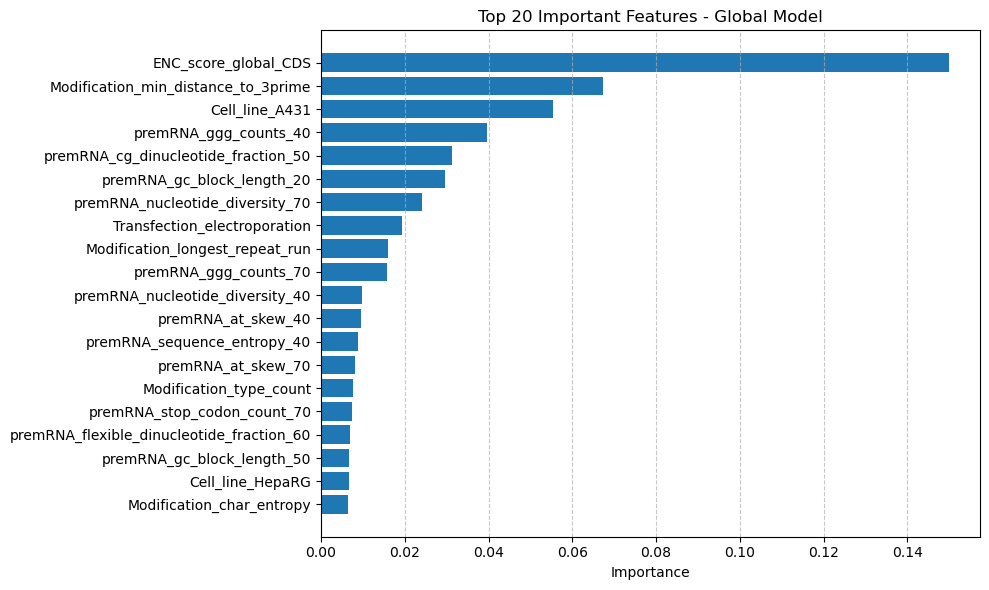

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

def show_feature_importance(model, feature_names, label, top_n=20):
    # Extract feature importance values
    importance = model.feature_importances_
    
    # Create DataFrame and sort descending
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Print full table
    print(f"\n🔎 Feature Importance - {label} Model:")
    print(imp_df.to_string(index=False))

    # Plot only top N
    top_imp_df = imp_df.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_imp_df['Feature'][::-1], top_imp_df['Importance'][::-1])  # reverse to show top at top
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Important Features - {label} Model")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


show_feature_importance(model_local, X_train_local.columns, "Local")
show_feature_importance(model_global, X_train_global.columns, "Global")



implement the local and global model without cell line and transfection